Install the necessary packages

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade 'tf-keras>2.16'
!pip install --upgrade transformers
!pip install --upgrade spacy_transformers
!pip install --upgrade sklearn matplotlib spacy

In [ ]:
!pip install alibi peft
!pip install sentencepiece
!pip install imblearn
!pip install --upgrade torch torchvision torchaudio transformers torchtext

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
# imports are always needed
import torch


# get index of currently selected device
print(torch.cuda.current_device()) # returns 0 in my case


# get number of GPUs available
print(torch.cuda.device_count()) # returns 1 in my case


# get the name of the device
print(torch.cuda.get_device_name(0)) # good old Tesla

print(torch.version.cuda)



Import the necessary packages

In [ ]:
import os
import spacy
import random
import pandas as pd
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import AdamW, SGD
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AutoTokenizer, AutoModel, pipeline
from alibi.explainers import AnchorText
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1 = pd.read_excel('/content/drive/MyDrive/Data_Sets/final_labels_SG1.xlsx')
df2 = pd.read_excel('/content/drive/MyDrive/Data_Sets/final_labels_SG2.xlsx')

Set the random seed for reproducibility

In [ ]:
# set seed, TF uses python ramdom and numpy library, so these must also be fixed
#tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)
os.environ['PYTHONHASHSEED']=str(0)
os.environ['TF_DETERMINISTIC_OPS'] = '0'

In [ ]:
df1 = pd.read_excel('/content/drive/MyDrive/final_labels_SG1.xlsx')
df2 = pd.read_excel('/content/drive/MyDrive/final_labels_SG2.xlsx')

In [ ]:
df1.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,The Republican president assumed he was helpin...,http://www.msnbc.com/rachel-maddow-show/auto-i...,msnbc,environment,left,Biased,Expresses writer’s opinion,[]
1,Though the indictment of a woman for her own p...,https://eu.usatoday.com/story/news/nation/2019...,usa-today,abortion,center,Non-biased,Somewhat factual but also opinionated,[]
2,Ingraham began the exchange by noting American...,https://www.breitbart.com/economy/2020/01/12/d...,breitbart,immigration,right,No agreement,No agreement,['flood']
3,The tragedy of America’s 18 years in Afghanist...,http://feedproxy.google.com/~r/breitbart/~3/ER...,breitbart,international-politics-and-world-news,right,Biased,Somewhat factual but also opinionated,"['tragedy', 'stubborn']"
4,The justices threw out a challenge from gun ri...,https://www.huffpost.com/entry/supreme-court-g...,msnbc,gun-control,left,Non-biased,Entirely factual,[]


In [ ]:
df2.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,"""Orange Is the New Black"" star Yael Stone is r...",https://www.foxnews.com/entertainment/australi...,Fox News,environment,right,Non-biased,Entirely factual,[]
1,"""We have one beautiful law,"" Trump recently sa...",https://www.alternet.org/2020/06/law-and-order...,Alternet,gun control,left,Biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']"
2,"...immigrants as criminals and eugenics, all o...",https://www.nbcnews.com/news/latino/after-step...,MSNBC,white-nationalism,left,Biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']"
3,...we sounded the alarm in the early months of...,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white-nationalism,left,Biased,Somewhat factual but also opinionated,[]
4,[Black Lives Matter] is essentially a non-fals...,http://feedproxy.google.com/~r/breitbart/~3/-v...,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,['cult']


Preprocess the data, remove rows with no agreement and convert the labels to binary

In [ ]:
df1 = df1[df1['label_bias']!='No agreement']
df1.replace(to_replace='Biased', value=1, inplace=True)
df1.replace(to_replace='Non-biased', value=0, inplace=True)

<ipython-input-6-63335be02dd0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace(to_replace='Biased', value=1, inplace=True)
<ipython-input-6-63335be02dd0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace(to_replace='Non-biased', value=0, inplace=True)


In [ ]:
df2 = df2[df2['label_bias']!='No agreement']
df2.replace(to_replace='Biased', value=1, inplace=True)
df2.replace(to_replace='Non-biased', value=0, inplace=True)

<ipython-input-7-9b46a2d081cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.replace(to_replace='Biased', value=1, inplace=True)
<ipython-input-7-9b46a2d081cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.replace(to_replace='Non-biased', value=0, inplace=True)


Number of labels: 2


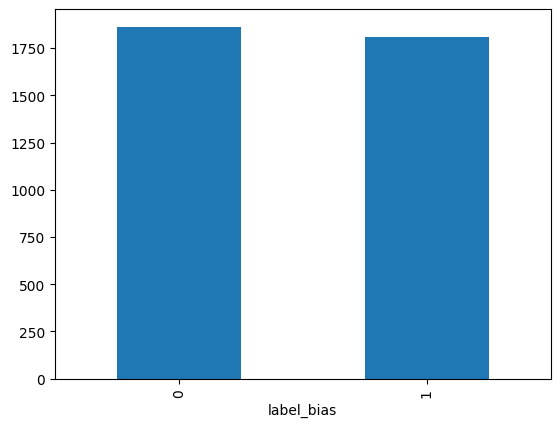

In [ ]:
# plot labels
df2['label_bias'].value_counts().plot(kind='bar')
num_labels = len(df2['label_bias'].unique())
print("Number of labels:", num_labels)

Define the stratified k-fold instance

In [ ]:
# Stratified k-Fold instance
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Define the functions to be used in the primary models. These functions are used to convert the pandas dataframe into a tensorflow dataset, plot the training history, plot the confusion matrix, and tokenize the data for the transformer model. Additionaly some experiments were performed with custom loss and custom structure for improving the performance.

In [ ]:
# helper functions called in skfold loop

def pd_to_tf(df):
    """convert a pandas dataframe into a tensorflow dataset"""
    target = df.pop('label_bias')
    sentence = df.pop('text')
    return tf.data.Dataset.from_tensor_slices((sentence.values, target.values))

def plot_graphs(history, metric, filename):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.savefig(filename)
  plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, filename):
    """Plots a confusion matrix as a heatmap and saves it as a PNG file."""
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    # Create a heatmap from the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)

    # Set labels and title
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)

    # Save the figure
    plt.savefig(filename)
    plt.show()

def tokenize(df):
    """convert a pandas dataframe into a tensorflow dataset and run hugging face's tokenizer on data"""
    target = df.pop('label_bias')
    sentence = df.pop('text')

    train_encodings = tokenizer(
                        sentence.tolist(),
                        add_special_tokens = True, # add [CLS], [SEP]
                        truncation = True, # cut off at max length of the text that can go to BERT
                        padding = True, # add [PAD] tokens
                        return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(train_encodings),
         target.tolist()))
    return dataset


class CustomModel(nn.Module):
    def __init__(self, base_model, num_labels, hidden_size=768):
        # num_labels is used here to generate two class probabilites, in order
        # to prepare the model for loss backward and optimization process
        super(CustomModel, self).__init__()
        self.roberta = base_model
        self.conv1d = nn.Conv1d(hidden_size, 128, kernel_size=5, padding=2)
        self.maxpool = nn.MaxPool1d(kernel_size=5)
        self.batchnorm = nn.BatchNorm1d(128)
        self.gru = nn.GRU(128, 128, batch_first=True, bidirectional=True)
        self.global_maxpool = nn.AdaptiveMaxPool1d(1)
        self.dense1 = nn.Linear(256, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(256, 1024)
        self.dropout2 = nn.Dropout(0.5)
        self.dense3 = nn.Linear(1024, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask, labels=labels, output_hidden_states=True)
        #print(len(outputs))

        # Extract the sequence output from the last layer
        sequence_output = outputs.hidden_states[-1] # (batch_size, sequence_length, hidden_size)

        # Debug: print the shape of sequence_output
        #print(f"Shape of sequence_output: {sequence_output.shape}")

        # Apply Conv1D and MaxPooling
        x = sequence_output.permute(0, 2, 1)  # Change shape to (batch_size, hidden_size, sequence_length)

        # Debug: print the shape after permute
        #print(f"Shape after permute: {x.shape}")

        # Apply Conv1D and MaxPooling
        x = sequence_output.permute(0, 2, 1)  # Change shape to (batch_size, hidden_size, seq_len)
        x = self.conv1d(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.batchnorm(x)

        # Apply GRU
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, seq_len, hidden_size)
        x, _ = self.gru(x)

        # Global Max Pooling
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, num_filters, seq_len)
        x = self.global_maxpool(x).squeeze(-1)  # Shape: (batch_size, num_filters)

        # Fully connected layers
        x = F.relu(self.dense1(x))
        x = self.dropout1(x)
        x = F.relu(self.dense2(x))
        x = self.dropout2(x)
        logits = self.dense3(x)

        return logits


# Define a function to merge LoRA weights back into the base model
def merge_lora_weights(model):
    for name, module in model.named_modules():
        if isinstance(module, LoraLayer):
            # Retrieve the original weights and the LoRA weights
            original_weights = getattr(model, name.replace('.', '_orig'))
            lora_weights = module.get_lora_weights()

            # Merge the weights
            with torch.no_grad():
                original_weights += lora_weights
            # Remove LoRA layer from the model
            setattr(model, name, original_weights)

    return model


# Define the custom loss function that includes a specific type of (accuracy, MCC, ...) penalty
# These penalty terms are known to be indifferentiable however it was observed that by training the model
# with CE_loss and then with some of them. They improve the overall execution.
# Further experiments are needed TO provide concrete evidence
# Among them accuracy penalty shows better results
def custom_loss_function(outputs, labels, alpha=2.0):
    # alpha = 1.0 for the first run

    ce_loss = F.cross_entropy(outputs, labels)

    # Calculate probabilities from logits
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)
    preds_cpu = preds.cpu().numpy()
    labels_cpu = labels.cpu().numpy()
    # Calculate accuracy
    # correct_predictions = (preds == labels).sum().float()
    # accuracy = correct_predictions / labels.size(0)

    # accuracy_penalty = 1 - accuracy

    # loss = ce_loss + alpha * accuracy_penalty

    # Calculate MCC
    mcc = matthews_corrcoef(labels_cpu, preds_cpu)

    mcc_penalty = 1 - mcc

    loss = ce_loss

    # Calculate missclassified rate
    # incorrect_predictions = (preds != labels).sum().float()
    # missclassified_rate = incorrect_predictions / labels.size(0)

    # missclassified_rate_penalty = missclassified_rate

    # loss = ce_loss + alpha * missclassified_rate_penalty
    # Calculate weighted F1 score
    # f1 = f1_score(labels_cpu, preds_cpu, average='weighted')
    # f1_penalty = 1 - f1

    # loss = ce_loss + alpha * f1_penalty
    return loss

Define the function to run the model. This function takes in the training data, the name of the file, and the flags to freeze the encoder layer and use pretrained weights. It returns the validation loss, accuracy, precision, recall, f1 score, micro f1 score, and weighted macro f1 score.
I moved to Pytorch from the original implementation in tensorflow due to the slight performance difference(need to be investigated).


The following cells are the final implementation for the model, the first one only finetune the LLM while with the second approach I try to improve the result by adding additional layers.
The results reported in my long report contains the metrics from both pure LLM and in addition to the CustomModel.
To find a good architechture for the deep learning model, I tried with a few different structure through CustomModel function,  the potential improvement is between [0.2,2]\%. This needs further validation including changing the placement of these layers.
Note: LORA finetuning is not necessary in case of RoBERTa and IS added for the next experiment with Llama 2 model.

In [ ]:
def run_model(named_file, freeze_encoder=True, pretrained=False, plot=False, init_type=None, learning_rate=1e-5, use_lora=False, use_custom_model=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the tokenizer and model
    model = RobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')

    # Check if checkpoint exists and load it
    checkpoint_path = f'/content/drive/MyDrive/{named_file}_Roberta_fine_tuned.pt'
    if use_custom_model:
        if (os.path.exists(checkpoint_path) or os.path.exists(f'/content/drive/MyDrive/{named_file}_Roberta_full_model.pt')):
            # Load the full model if the full model file exist else initialize
            # the custom model using the custom function
            if os.path.exists(f'/content/drive/MyDrive/{named_file}_Roberta_full_model.pt'):
              model = torch.load(f'/content/drive/MyDrive/{named_file}_Roberta_full_model.pt')
            else:
              model = CustomModel(base_model=model, num_labels=2)
              model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        else:
            model = CustomModel(base_model=model, num_labels=2)
    else:
        checkpoint_path = f'/content/drive/MyDrive/{named_file}_Roberta_fine_tuned_pure.pt'
        if os.path.exists(checkpoint_path):
            model.load_state_dict(torch.load(checkpoint_path, map_location=device))

    model = model.to(device)

    if use_lora:
        # Apply LoRA
        lora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            inference_mode=False,
            r=16,  # rank of the low-rank adapters
            lora_alpha=32,
            lora_dropout=0.1
        )
        model = get_peft_model(model, lora_config)




    # with open('model_layers.txt', 'w') as f:
    #     for module in model.modules():
    #         f.write(f'Type: {type(module)}\n')

    # with open('model_arch.txt', 'w') as f:
    #     f.write(str(model))

    # with open('model_parameters.txt', 'w') as f:
    #     for name, param in model.named_parameters():
    #         f.write(f'{name}: {param.shape}\n')


    # if freeze_encoder:
        # Freeze all encoder parameters
        # for param in model.base_model.parameters():
        #     param.requires_grad = False
        # Specifically freeze position embeddings

    if freeze_encoder:
        # Freeze position embeddings
        for name, param in model.named_parameters():
            if 'roberta.embeddings.position_embeddings' in name:
                print(f'Freezing {name}')
                param.requires_grad = False
            if 'roberta.embeddings.token_type_embeddings' in name:
                print(f'Freezing {name}')
                param.requires_grad = False

        # Freeze early encoder layers (e.g., first 6 layers)
        for name, param in model.named_parameters():
            if 'roberta.encoder.layer' in name:
                if use_custom_model:
                    layer_number = int(name.split('.')[4])  # Extract layer number
                    if layer_number < 6:  # Freeze first 6 layers
                        param.requires_grad = False
                        print(f'Freezing {name}')
                else:
                    layer_number = int(name.split('.')[3])  # Extract layer number
                    if layer_number < 6:  # Freeze first 6 layers
                        param.requires_grad = False
                        print(f'Freezing {name}')

    # Initialize weights based on the init_type
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            if init_type == 'xavier':
                torch.nn.init.xavier_uniform_(m.weight)
            elif init_type == 'kaiming':
                torch.nn.init.kaiming_uniform_(m.weight)
            elif init_type == 'orthogonal':
                torch.nn.init.orthogonal_(m.weight)
            elif init_type == 'zero':
                torch.nn.init.zeros_(m.weight)
            m.bias.data.fill_(0.01)

    if init_type is not None:
        model.apply(init_weights)

    # Define the loss function and optimizer
    loss_function = torch.nn.CrossEntropyLoss()
    #loss_function = torch.nn.NLLLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate)

    # Tokenize the data
    train_encodings = tokenizer(X_train_resampled, truncation=True, padding=True, add_special_tokens=True, return_attention_mask=True)
    val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True, add_special_tokens=True, return_attention_mask=True)
    test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, add_special_tokens=True, return_attention_mask=True)

    train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(y_train_resampled))
    val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(y_val.tolist()))
    test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']), torch.tensor(test_encodings['attention_mask']), torch.tensor(y_test.tolist()))

    # Create data loaders tested 64, 16 but 8 is the best for learning stability
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


    train_losses = []
    val_losses = []

    # Training loop
    best_val_loss = float('inf')
    iteration = 0
    for epoch in range(15):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            #print(batch[0])
            #print(batch[1])
            #print(batch[2])
            optimizer.zero_grad()
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device).long()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            #print(outputs)
            #print("Shape of outputs.logits:", outputs.logits.shape)
            #print("Shape of labels:", labels.shape)
            if use_custom_model:
                loss = custom_loss_function(outputs, labels)
            else:
                loss = custom_loss_function(outputs.logits, labels)
            loss.backward()

            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}, Train Loss: {epoch_loss}')

        # Validation
        model.eval()
        val_loss = 0
        y_pred = []
        y_true = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device).long()
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                if use_custom_model:
                    val_loss += custom_loss_function(outputs, labels)#.item()
                else:
                    val_loss += custom_loss_function(outputs.logits, labels)#.item()
                # Convert the logits to class labels
                if use_custom_model:
                    _, preds = torch.max(outputs, dim=1)
                else:
                    _, preds = torch.max(outputs.logits, dim=1)
                y_pred.extend(preds.tolist())
                y_true.extend(labels.tolist())
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss}')

        iteration += 1
        # Save the model
        if iteration%5 == 0:
        #if val_loss < best_val_loss:
            #best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)

    # savng the full model as well
    if use_custom_model:
        # Save the full model
        torch.save(model, f'/content/drive/MyDrive/{named_file}_Roberta_full_model.pt')
    # Test
    model.eval()
    test_loss = 0
    y_pred_test = []
    y_true_test = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device).long()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            if use_custom_model:
                test_loss += custom_loss_function(outputs, labels)#.item()
            else:
                test_loss += custom_loss_function(outputs.logits, labels)#.item()
            # Convert the logits to class labels
            if use_custom_model:
                _, preds = torch.max(outputs, dim=1)
            else:
                _, preds = torch.max(outputs.logits, dim=1)
            y_pred_test.extend(preds.tolist())
            y_true_test.extend(labels.tolist())
    test_loss = test_loss / len(test_loader)

    # calculate the metrics
    test_acc = accuracy_score(y_true_test, y_pred_test)
    test_prec = precision_score(y_true_test, y_pred_test, average='binary')
    test_rec = recall_score(y_true_test, y_pred_test, average='binary')
    test_f1 = f1_score(y_true_test, y_pred_test, average='binary')
    test_f1_micro = f1_score(y_true_test, y_pred_test, average='micro')
    test_f1_wmacro = f1_score(y_true_test, y_pred_test, average='weighted')

    # Plotting
    if plot:
        # Plot training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.title('Losses')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    # Plot confusion matrix
    plot_confusion_matrix(y_true_test, y_pred_test, ['Non-biased', 'Biased'], f'{named_file}_confusion_matrix.png')

    return test_loss, test_acc, test_prec, test_rec, test_f1, test_f1_micro, test_f1_wmacro

Now run the model in two forms on SG1.

*   The data are made with specified random_state
*   The data are saved to pickle with consideration for future usage

for re-execution consider loading the data from every second cells before
'run_model'


model with filename containing suffix '_C' are pure model without the addition of Custom structure

In [ ]:
#Without Oversampling
df_train = df1

# Prepare the data
X = df_train['text']
y = df_train['label_bias']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
#print(len(X_train))
#print(len(X_test))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=23) # Further split train set into train and validation
#print(len(X_train))
#print(len(X_val))
X_train_resampled, y_train_resampled = X_train.to_list(), y_train.to_list()

data_to_save = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'X_val': X_val,
    'y_val': y_val,
    'X_train_resampled': X_train_resampled,
    'y_train_resampled': y_train_resampled
}

# Save the variables to a file
with open('/content/drive/MyDrive/Models/In_data/SG1_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


In [ ]:
# This snippet can load the data for training the model in two next snippets
# Load the variables from the file
with open('/content/drive/MyDrive/Models/In_data/SG1_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Assign the loaded variables back to original variable names
X_train = loaded_data['X_train']
X_test = loaded_data['X_test']
y_train = loaded_data['y_train']
y_test = loaded_data['y_test']
X_val = loaded_data['X_val']
y_val = loaded_data['y_val']
X_train_resampled = loaded_data['X_train_resampled']
y_train_resampled = loaded_data['y_train_resampled']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-a7d58b4e01d6>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explic

Epoch 1, Train Loss: 0.011779753356633239
Epoch 1, Val Loss: 1.7734761238098145
Epoch 2, Train Loss: 8.658801514303054e-05
Epoch 2, Val Loss: 1.922896385192871
Epoch 3, Train Loss: 0.05365904904186891
Epoch 3, Val Loss: 1.3006091117858887
Epoch 4, Train Loss: 0.017555719937879456
Epoch 4, Val Loss: 1.6706936359405518
Epoch 5, Train Loss: 0.0004572850662483571
Epoch 5, Val Loss: 1.752394437789917
Epoch 6, Train Loss: 0.0022193664231787307
Epoch 6, Val Loss: 2.044496536254883
Epoch 7, Train Loss: 0.0017619249122382767
Epoch 7, Val Loss: 1.708089828491211
Epoch 8, Train Loss: 0.00010263793084167475
Epoch 8, Val Loss: 1.7789089679718018
Epoch 9, Train Loss: 0.016163382506405352
Epoch 9, Val Loss: 0.9213975071907043
Epoch 10, Train Loss: 0.0028437066268100263
Epoch 10, Val Loss: 1.4562541246414185
Epoch 11, Train Loss: 0.0002631002311494329
Epoch 11, Val Loss: 1.650078535079956
Epoch 12, Train Loss: 0.0014384495747538407
Epoch 12, Val Loss: 1.8966835737228394
Epoch 13, Train Loss: 0.0207071

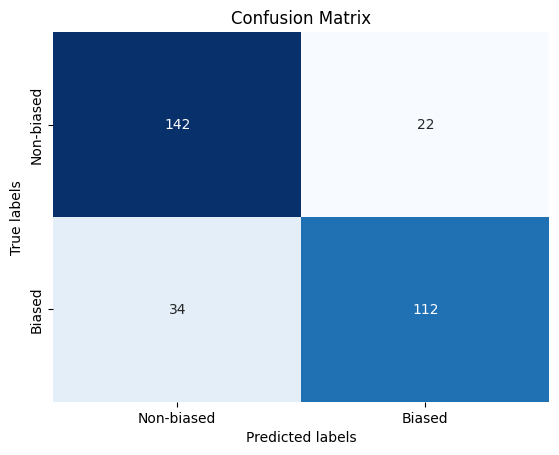

Results for Roberta on SG1
Test Loss: 1.293222427368164
Test Accuracy: 0.8193548387096774
Test Precision: 0.835820895522388
Test Recall: 0.7671232876712328
Test F1 Score: 0.8
Test Micro F1 Score: 0.8193548387096774
Test Weighted Macro F1 Score: 0.8186717267552182


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
test_loss, test_acc, test_prec, test_rec, test_f1, test_f1_micro, test_f1_wmacro = run_model(named_file='df1',freeze_encoder=False, pretrained=False, plot=False, init_type=None, learning_rate=2e-5, use_lora=False, use_custom_model=True)

print('Results for Roberta on SG1')
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))
print('Test Precision: {}'.format(test_prec))
print('Test Recall: {}'.format(test_rec))
print('Test F1 Score: {}'.format(test_f1))
print('Test Micro F1 Score: {}'.format(test_f1_micro))
print('Test Weighted Macro F1 Score: {}'.format(test_f1_wmacro))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-a7d58b4e01d6>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explic

Epoch 1, Train Loss: 0.016188241166402453
Epoch 1, Val Loss: 1.6506894826889038
Epoch 2, Train Loss: 0.02872950474841585
Epoch 2, Val Loss: 1.1406539678573608
Epoch 3, Train Loss: 0.00039001133474460313
Epoch 3, Val Loss: 1.24295175075531
Epoch 4, Train Loss: 0.0004059945184112181
Epoch 4, Val Loss: 1.3681883811950684
Epoch 5, Train Loss: 2.9512378307939094e-05
Epoch 5, Val Loss: 1.3882739543914795
Epoch 6, Train Loss: 3.43319840075926e-05
Epoch 6, Val Loss: 1.4075480699539185
Epoch 7, Train Loss: 0.0003446044173092706
Epoch 7, Val Loss: 1.6327388286590576
Epoch 8, Train Loss: 9.91794253745719e-05
Epoch 8, Val Loss: 1.5164761543273926
Epoch 9, Train Loss: 0.00014239040097568397
Epoch 9, Val Loss: 1.5405542850494385
Epoch 10, Train Loss: 0.015282198084587289
Epoch 10, Val Loss: 1.1760269403457642
Epoch 11, Train Loss: 0.02871326971208257
Epoch 11, Val Loss: 1.4120957851409912
Epoch 12, Train Loss: 0.01830989281828102
Epoch 12, Val Loss: 1.1991134881973267
Epoch 13, Train Loss: 0.0131965

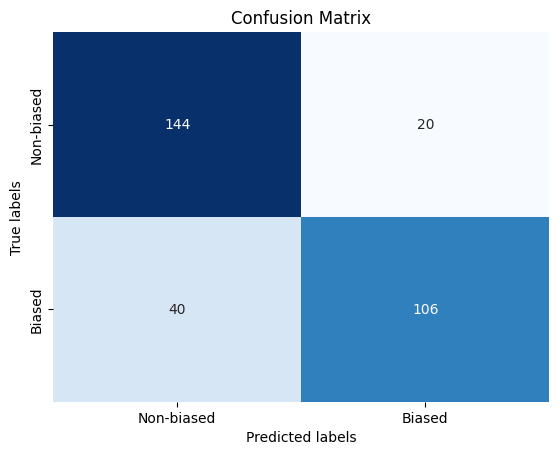

Results for Roberta on SG1
Test Loss: 1.1023160219192505
Test Accuracy: 0.8064516129032258
Test Precision: 0.8412698412698413
Test Recall: 0.726027397260274
Test F1 Score: 0.7794117647058825
Test Micro F1 Score: 0.8064516129032258
Test Weighted Macro F1 Score: 0.8048975986390108


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
test_loss, test_acc, test_prec, test_rec, test_f1, test_f1_micro, test_f1_wmacro = run_model(named_file='df1_c',freeze_encoder=False, pretrained=False, plot=False, init_type=None, learning_rate=2e-5, use_lora=False, use_custom_model=False)

print('Results for Roberta on SG1')
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))
print('Test Precision: {}'.format(test_prec))
print('Test Recall: {}'.format(test_rec))
print('Test F1 Score: {}'.format(test_f1))
print('Test Micro F1 Score: {}'.format(test_f1_micro))
print('Test Weighted Macro F1 Score: {}'.format(test_f1_wmacro))


In [ ]:
df_train = df1

# Prepare the data
X = df_train['text']
y = df_train['label_bias']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
#print(len(X_train))
#print(len(X_test))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=23) # Further split train set into train and validation
#print(len(X_train))
#print(len(X_val))

# Apply oversampling to the training data
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(np.array(X_train).reshape(-1, 1), y_train)
X_train_resampled = X_train_resampled.ravel().tolist()

data_to_save = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'X_val': X_val,
    'y_val': y_val,
    'X_train_resampled': X_train_resampled,
    'y_train_resampled': y_train_resampled
}

# Save the variables to a file
with open('/content/drive/MyDrive/Models/In_data/SG1_ov_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

In [ ]:
# This snippet can load the data for training the model in two next snippets
# Load the variables from the file
with open('/content/drive/MyDrive/Models/In_data/SG1_ov_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Assign the loaded variables back to your original variable names
X_train = loaded_data['X_train']
X_test = loaded_data['X_test']
y_train = loaded_data['y_train']
y_test = loaded_data['y_test']
X_val = loaded_data['X_val']
y_val = loaded_data['y_val']
X_train_resampled = loaded_data['X_train_resampled']
y_train_resampled = loaded_data['y_train_resampled']

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-a7d58b4e01d6>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explic

Epoch 1, Train Loss: 0.0065210981100825354
Epoch 1, Val Loss: 1.949509859085083
Epoch 2, Train Loss: 0.01258649164064991
Epoch 2, Val Loss: 1.9035711288452148
Epoch 3, Train Loss: 0.0005838623276409076
Epoch 3, Val Loss: 1.9799317121505737
Epoch 4, Train Loss: 0.006753590895725491
Epoch 4, Val Loss: 1.7016773223876953
Epoch 5, Train Loss: 0.0005736336292382195
Epoch 5, Val Loss: 2.0127761363983154
Epoch 6, Train Loss: 0.004034540380227834
Epoch 6, Val Loss: 2.396939754486084
Epoch 7, Train Loss: 0.033768092436660554
Epoch 7, Val Loss: 1.222764492034912
Epoch 8, Train Loss: 0.03119558942965411
Epoch 8, Val Loss: 1.4654985666275024
Epoch 9, Train Loss: 0.1938583723627604
Epoch 9, Val Loss: 0.5445809364318848
Epoch 10, Train Loss: 0.033058343958467816
Epoch 10, Val Loss: 0.7198595404624939
Epoch 11, Train Loss: 0.029608168068359822
Epoch 11, Val Loss: 0.596886932849884
Epoch 12, Train Loss: 0.03987122924837212
Epoch 12, Val Loss: 0.7843984961509705
Epoch 13, Train Loss: 0.0170927982246212

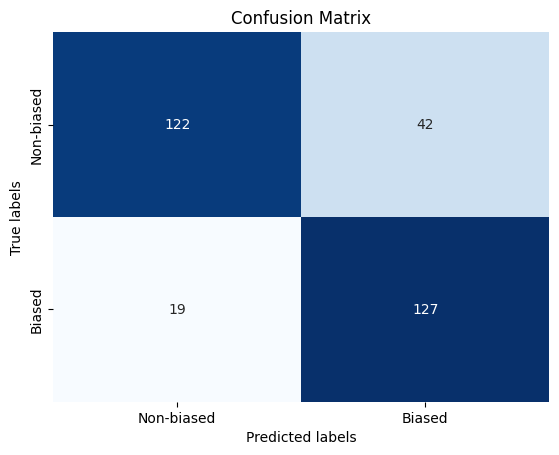

Results for Roberta on SG1
Test Loss: 0.8586797714233398
Test Accuracy: 0.8032258064516129
Test Precision: 0.7514792899408284
Test Recall: 0.8698630136986302
Test F1 Score: 0.8063492063492064
Test Micro F1 Score: 0.8032258064516129
Test Weighted Macro F1 Score: 0.8029902713773682


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
test_loss, test_acc, test_prec, test_rec, test_f1, test_f1_micro, test_f1_wmacro = run_model(named_file='df1_ov',freeze_encoder=False, pretrained=False, plot=False, init_type=None, learning_rate=2e-5, use_lora=False, use_custom_model=True)

print('Results for Roberta on SG1')
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))
print('Test Precision: {}'.format(test_prec))
print('Test Recall: {}'.format(test_rec))
print('Test F1 Score: {}'.format(test_f1))
print('Test Micro F1 Score: {}'.format(test_f1_micro))
print('Test Weighted Macro F1 Score: {}'.format(test_f1_wmacro))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-a7d58b4e01d6>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explic

Epoch 1, Train Loss: 0.0015088485312547233
Epoch 1, Val Loss: 2.09911847114563
Epoch 2, Train Loss: 0.012776274067606699
Epoch 2, Val Loss: 1.8156629800796509
Epoch 3, Train Loss: 0.012037347260831246
Epoch 3, Val Loss: 1.5355267524719238
Epoch 4, Train Loss: 7.219332002513021e-05
Epoch 4, Val Loss: 1.639512538909912
Epoch 5, Train Loss: 4.4836825019536685e-05
Epoch 5, Val Loss: 1.7000280618667603
Epoch 6, Train Loss: 3.202793136901724e-05
Epoch 6, Val Loss: 1.7430665493011475
Epoch 7, Train Loss: 2.479969959425104e-05
Epoch 7, Val Loss: 1.7763949632644653
Epoch 8, Train Loss: 2.0758238007636884e-05
Epoch 8, Val Loss: 1.8042736053466797
Epoch 9, Train Loss: 1.7240691522601993e-05
Epoch 9, Val Loss: 1.827703595161438
Epoch 10, Train Loss: 1.4634565601367144e-05
Epoch 10, Val Loss: 1.8476336002349854
Epoch 11, Train Loss: 1.2983853685000213e-05
Epoch 11, Val Loss: 1.8658385276794434
Epoch 12, Train Loss: 1.17639270194139e-05
Epoch 12, Val Loss: 1.8819587230682373
Epoch 13, Train Loss: 1.

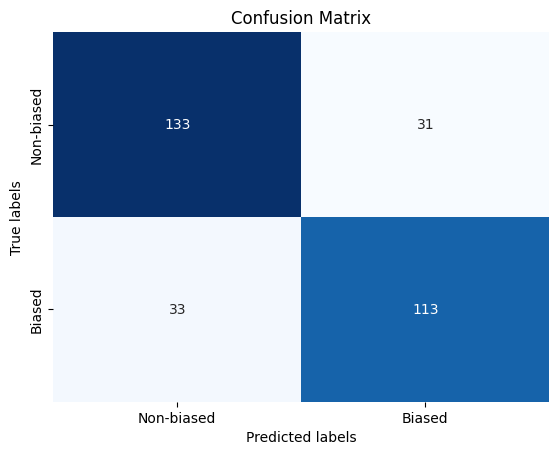

Results for Roberta on SG1
Test Loss: 2.241250991821289
Test Accuracy: 0.7935483870967742
Test Precision: 0.7847222222222222
Test Recall: 0.773972602739726
Test F1 Score: 0.7793103448275863
Test Micro F1 Score: 0.7935483870967742
Test Weighted Macro F1 Score: 0.7934620959315064


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
test_loss, test_acc, test_prec, test_rec, test_f1, test_f1_micro, test_f1_wmacro = run_model(named_file='df1_ov_c',freeze_encoder=False, pretrained=False, plot=False, init_type=None, learning_rate=2e-5, use_lora=False, use_custom_model=False)

print('Results for Roberta on SG1')
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))
print('Test Precision: {}'.format(test_prec))
print('Test Recall: {}'.format(test_rec))
print('Test F1 Score: {}'.format(test_f1))
print('Test Micro F1 Score: {}'.format(test_f1_micro))
print('Test Weighted Macro F1 Score: {}'.format(test_f1_wmacro))


Run the model similarily on SG2

In [ ]:
#Without Oversampling
df_train = df2

# Prepare the data
X = df_train['text']
y = df_train['label_bias']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
#print(len(X_train))
#print(len(X_test))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=23) # Further split train set into train and validation
#print(len(X_train))
#print(len(X_val))
X_train_resampled, y_train_resampled = X_train.to_list(), y_train.to_list()

data_to_save = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'X_val': X_val,
    'y_val': y_val,
    'X_train_resampled': X_train_resampled,
    'y_train_resampled': y_train_resampled
}

# Save the variables to a file
with open('/content/drive/MyDrive/Models/In_data/SG2_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

In [ ]:
# Load the variables from the file
with open('/content/drive/MyDrive/Models/In_data/SG2_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

X_train = loaded_data['X_train']
X_test = loaded_data['X_test']
y_train = loaded_data['y_train']
y_test = loaded_data['y_test']
X_val = loaded_data['X_val']
y_val = loaded_data['y_val']
X_train_resampled = loaded_data['X_train_resampled']
y_train_resampled = loaded_data['y_train_resampled']

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-a7d58b4e01d6>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explic

Epoch 1, Train Loss: 1.3988734065286562e-08
Epoch 1, Val Loss: 4.922772407531738
Epoch 2, Train Loss: 2.0273686886503438e-10
Epoch 2, Val Loss: 4.95272159576416
Epoch 3, Train Loss: 0.020463264206653654
Epoch 3, Val Loss: 4.353308200836182
Epoch 4, Train Loss: 0.0004550769255159834
Epoch 4, Val Loss: 3.021785020828247
Epoch 5, Train Loss: 0.0003922856470783574
Epoch 5, Val Loss: 3.545992136001587
Epoch 6, Train Loss: 4.327856426998973e-06
Epoch 6, Val Loss: 3.7851781845092773
Epoch 7, Train Loss: 3.4966452568921713e-06
Epoch 7, Val Loss: 4.025570392608643
Epoch 8, Train Loss: 0.003950058697102948
Epoch 8, Val Loss: 3.9734010696411133
Epoch 9, Train Loss: 0.0010197979758407357
Epoch 9, Val Loss: 4.920294284820557
Epoch 10, Train Loss: 0.0045855212262598255
Epoch 10, Val Loss: 3.973482847213745
Epoch 11, Train Loss: 0.01935148333101174
Epoch 11, Val Loss: 4.004291534423828
Epoch 12, Train Loss: 0.006167588436869958
Epoch 12, Val Loss: 3.7295026779174805
Epoch 13, Train Loss: 0.0050488524

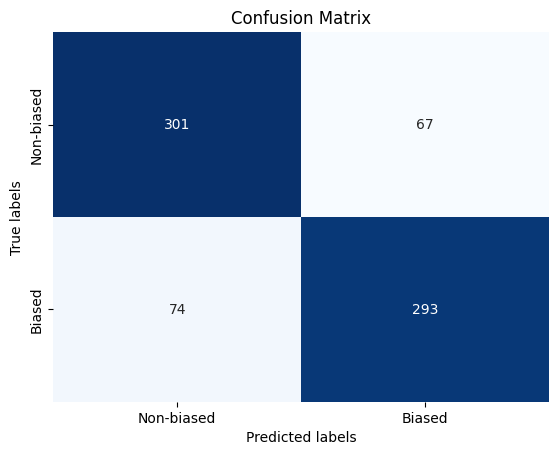

Results for Roberta on SG2
Test Loss: 3.659761905670166
Test Accuracy: 0.8081632653061225
Test Precision: 0.8138888888888889
Test Recall: 0.7983651226158038
Test F1 Score: 0.8060522696011003
Test Micro F1 Score: 0.8081632653061225
Test Weighted Macro F1 Score: 0.8081433770558732


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
test_loss, test_acc, test_prec, test_rec, test_f1, test_f1_micro, test_f1_wmacro = run_model(named_file='df2',freeze_encoder=False, pretrained=False, plot=False, init_type=None, learning_rate=2e-5, use_lora=False, use_custom_model=True)

print('Results for Roberta on SG2')
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))
print('Test Precision: {}'.format(test_prec))
print('Test Recall: {}'.format(test_rec))
print('Test F1 Score: {}'.format(test_f1))
print('Test Micro F1 Score: {}'.format(test_f1_micro))
print('Test Weighted Macro F1 Score: {}'.format(test_f1_wmacro))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-a7d58b4e01d6>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explic

Epoch 1, Train Loss: 0.01675276010372523
Epoch 1, Val Loss: 1.1847110986709595
Epoch 2, Train Loss: 0.011733314955674768
Epoch 2, Val Loss: 1.3610188961029053
Epoch 3, Train Loss: 0.0021636116867417747
Epoch 3, Val Loss: 1.539384126663208
Epoch 4, Train Loss: 0.02139141789567617
Epoch 4, Val Loss: 1.2494217157363892
Epoch 5, Train Loss: 0.01655982199043224
Epoch 5, Val Loss: 1.3236151933670044
Epoch 6, Train Loss: 0.0003961257297348874
Epoch 6, Val Loss: 1.5084507465362549
Epoch 7, Train Loss: 0.025073119375185936
Epoch 7, Val Loss: 1.2078062295913696
Epoch 8, Train Loss: 0.02210412434150614
Epoch 8, Val Loss: 1.2371498346328735
Epoch 9, Train Loss: 0.005120482388111687
Epoch 9, Val Loss: 1.4231717586517334
Epoch 10, Train Loss: 0.00943182459889854
Epoch 10, Val Loss: 1.2506052255630493
Epoch 11, Train Loss: 0.028166200446723612
Epoch 11, Val Loss: 1.1260039806365967
Epoch 12, Train Loss: 0.006265722667324424
Epoch 12, Val Loss: 1.4851727485656738
Epoch 13, Train Loss: 0.03029160961951

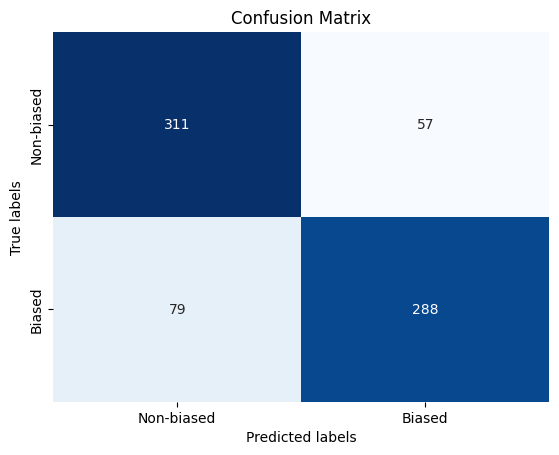

Results for Roberta on SG2
Test Loss: 1.166406273841858
Test Accuracy: 0.8149659863945579
Test Precision: 0.8347826086956521
Test Recall: 0.784741144414169
Test F1 Score: 0.8089887640449438
Test Micro F1 Score: 0.8149659863945579
Test Weighted Macro F1 Score: 0.8147925050071019


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
test_loss, test_acc, test_prec, test_rec, test_f1, test_f1_micro, test_f1_wmacro = run_model(named_file='df2_c',freeze_encoder=False, pretrained=False, plot=False, init_type=None, learning_rate=2e-5, use_lora=False, use_custom_model=False)

print('Results for Roberta on SG2')
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))
print('Test Precision: {}'.format(test_prec))
print('Test Recall: {}'.format(test_rec))
print('Test F1 Score: {}'.format(test_f1))
print('Test Micro F1 Score: {}'.format(test_f1_micro))
print('Test Weighted Macro F1 Score: {}'.format(test_f1_wmacro))


In [ ]:
df_train = df2

# Prepare the data
X = df_train['text']
y = df_train['label_bias']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
#print(len(X_train))
#print(len(X_test))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=23) # Further split train set into train and validation
#print(len(X_train))
#print(len(X_val))

# Apply oversampling to the training data
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(np.array(X_train).reshape(-1, 1), y_train)
X_train_resampled = X_train_resampled.ravel().tolist()

data_to_save = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'X_val': X_val,
    'y_val': y_val,
    'X_train_resampled': X_train_resampled,
    'y_train_resampled': y_train_resampled
}

# Save the variables to a file
with open('/content/drive/MyDrive/Models/In_data/SG2_ov_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

In [ ]:
with open('/content/drive/MyDrive/Models/In_data/SG2_ov_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Assign the loaded variables back to your original variable names
X_train = loaded_data['X_train']
X_test = loaded_data['X_test']
y_train = loaded_data['y_train']
y_test = loaded_data['y_test']
X_val = loaded_data['X_val']
y_val = loaded_data['y_val']
X_train_resampled = loaded_data['X_train_resampled']
y_train_resampled = loaded_data['y_train_resampled']

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-a7d58b4e01d6>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explic

Epoch 1, Train Loss: 0.018424197521060212
Epoch 1, Val Loss: 1.4018503427505493
Epoch 2, Train Loss: 0.024904082370359626
Epoch 2, Val Loss: 1.6448185443878174
Epoch 3, Train Loss: 0.03476345198183573
Epoch 3, Val Loss: 1.1397924423217773
Epoch 4, Train Loss: 0.014969248001876097
Epoch 4, Val Loss: 1.203056812286377
Epoch 5, Train Loss: 0.032868052886575023
Epoch 5, Val Loss: 1.4245331287384033
Epoch 6, Train Loss: 0.022858866181923076
Epoch 6, Val Loss: 0.979801595211029
Epoch 7, Train Loss: 0.027260469260351274
Epoch 7, Val Loss: 0.9838505387306213
Epoch 8, Train Loss: 0.015738212642944577
Epoch 8, Val Loss: 0.9584060907363892
Epoch 9, Train Loss: 0.008546975870657184
Epoch 9, Val Loss: 1.036386251449585
Epoch 10, Train Loss: 0.016806217853840188
Epoch 10, Val Loss: 0.9664562344551086
Epoch 11, Train Loss: 0.019623038943085456
Epoch 11, Val Loss: 1.122865915298462
Epoch 12, Train Loss: 0.032625040830797675
Epoch 12, Val Loss: 0.9759140014648438
Epoch 13, Train Loss: 0.013860161613004

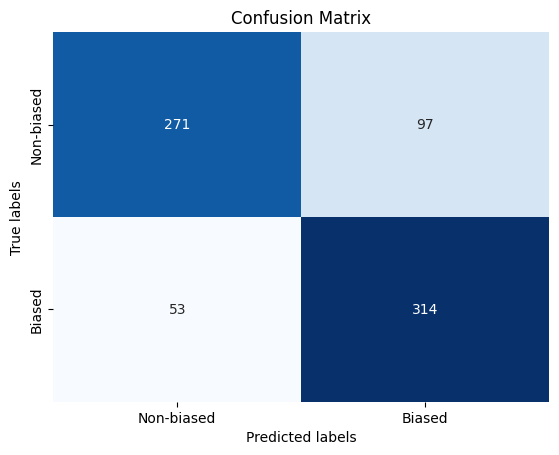

Results for Roberta on SG2
Test Loss: 0.6431417465209961
Test Accuracy: 0.7959183673469388
Test Precision: 0.7639902676399026
Test Recall: 0.8555858310626703
Test F1 Score: 0.8071979434447301
Test Micro F1 Score: 0.7959183673469388
Test Weighted Macro F1 Score: 0.7952011688667324


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
test_loss, test_acc, test_prec, test_rec, test_f1, test_f1_micro, test_f1_wmacro = run_model(named_file='df2_ov',freeze_encoder=False, pretrained=False, plot=False, init_type=None, learning_rate=2e-5, use_lora=False, use_custom_model=True)

print('Results for Roberta on SG2')
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))
print('Test Precision: {}'.format(test_prec))
print('Test Recall: {}'.format(test_rec))
print('Test F1 Score: {}'.format(test_f1))
print('Test Micro F1 Score: {}'.format(test_f1_micro))
print('Test Weighted Macro F1 Score: {}'.format(test_f1_wmacro))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-a7d58b4e01d6>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explic

Epoch 1, Train Loss: 0.016317889793843555
Epoch 1, Val Loss: 1.4015791416168213
Epoch 2, Train Loss: 0.008923382297384166
Epoch 2, Val Loss: 1.3100947141647339
Epoch 3, Train Loss: 0.0032790970222622952
Epoch 3, Val Loss: 1.3009321689605713
Epoch 4, Train Loss: 0.00709829153124316
Epoch 4, Val Loss: 1.4793927669525146
Epoch 5, Train Loss: 0.02999872166900925
Epoch 5, Val Loss: 0.889387309551239
Epoch 6, Train Loss: 0.010782127174616879
Epoch 6, Val Loss: 1.137407898902893
Epoch 7, Train Loss: 0.0013735438845025659
Epoch 7, Val Loss: 1.2965208292007446
Epoch 8, Train Loss: 0.01724519509985161
Epoch 8, Val Loss: 1.3290953636169434
Epoch 9, Train Loss: 0.018003525996188065
Epoch 9, Val Loss: 1.0728086233139038
Epoch 10, Train Loss: 0.007336395106010012
Epoch 10, Val Loss: 1.2364633083343506
Epoch 11, Train Loss: 0.001009727385752416
Epoch 11, Val Loss: 1.5023003816604614
Epoch 12, Train Loss: 0.013635866021896788
Epoch 12, Val Loss: 1.1779714822769165
Epoch 13, Train Loss: 0.0168932534925

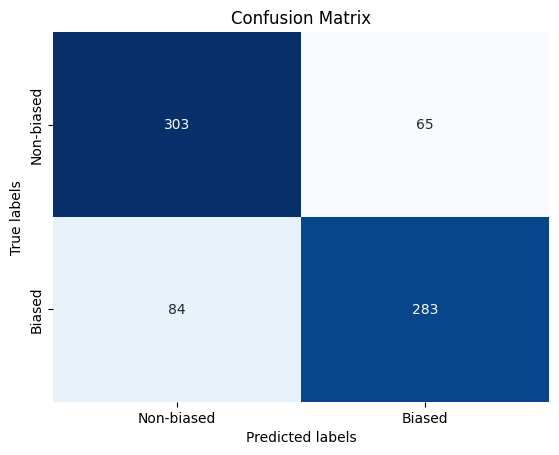

Results for Roberta on SG2
Test Loss: 1.056847095489502
Test Accuracy: 0.7972789115646258
Test Precision: 0.8132183908045977
Test Recall: 0.771117166212534
Test F1 Score: 0.7916083916083916
Test Micro F1 Score: 0.7972789115646258
Test Weighted Macro F1 Score: 0.7971362097379127


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
test_loss, test_acc, test_prec, test_rec, test_f1, test_f1_micro, test_f1_wmacro = run_model(named_file='df2_ov_c',freeze_encoder=False, pretrained=False, plot=False, init_type=None, learning_rate=2e-5, use_lora=False, use_custom_model=False)

print('Results for Roberta on SG2')
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))
print('Test Precision: {}'.format(test_prec))
print('Test Recall: {}'.format(test_rec))
print('Test F1 Score: {}'.format(test_f1))
print('Test Micro F1 Score: {}'.format(test_f1_micro))
print('Test Weighted Macro F1 Score: {}'.format(test_f1_wmacro))


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(df2, named_file='df2',freeze_encoder=False, pretrained=False, plot=True)
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('Results for Roberta on SG12')
print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

Applying Baseline functions to SG1 dataset

Majority Class Classifier Report:
              precision    recall  f1-score   support

           0  0.53870968 1.00000000 0.70020964       167
           1  0.00000000 0.00000000 0.00000000       143

    accuracy                      0.53870968       310
   macro avg  0.26935484 0.50000000 0.35010482       310
weighted avg  0.29020812 0.53870968 0.37720971       310



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



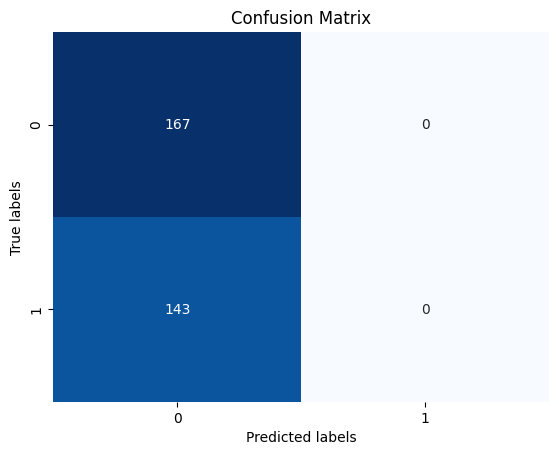

Random Guesser Report:
              precision    recall  f1-score   support

           0  0.55033557 0.49101796 0.51898734       167
           1  0.47204969 0.53146853 0.50000000       143

    accuracy                      0.50967742       310
   macro avg  0.51119263 0.51124325 0.50949367       310
weighted avg  0.51422305 0.50967742 0.51022866       310



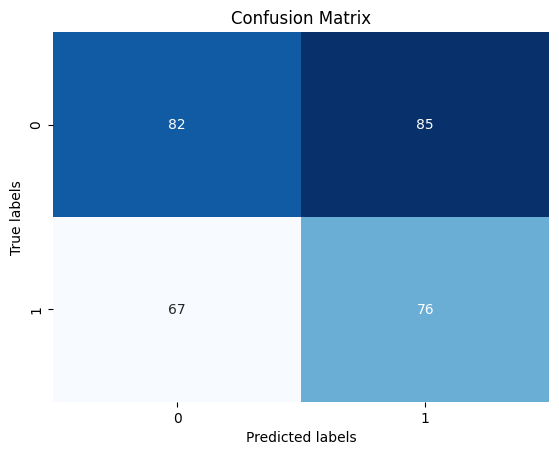

CountVectorizer with Logistic Regression Report:
              precision    recall  f1-score   support

           0  0.66878981 0.62874251 0.64814815       167
           1  0.59477124 0.63636364 0.61486486       143

    accuracy                      0.63225806       310
   macro avg  0.63178053 0.63255308 0.63150651       310
weighted avg  0.63464576 0.63225806 0.63279489       310



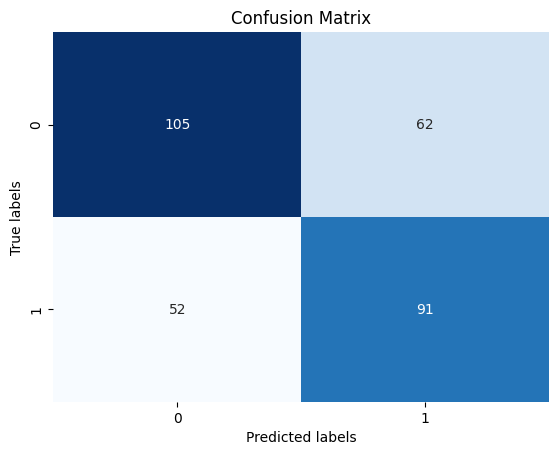

Neural Network Classifier Report:
              precision    recall  f1-score   support

           0  0.61643836 0.80838323 0.69948187       167
           1  0.64835165 0.41258741 0.50427350       143

    accuracy                      0.62580645       310
   macro avg  0.63239500 0.61048532 0.60187768       310
weighted avg  0.63115965 0.62580645 0.60943414       310



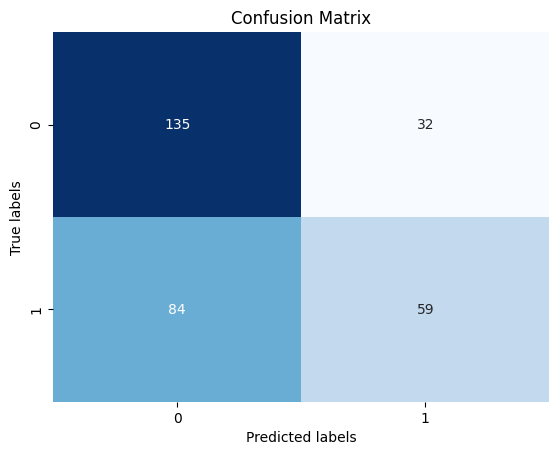

In [ ]:
# Assuming df is the DataFrame and "text" and "label_bias" are the columns
X = df1['text']
y = df1['label_bias']

# Split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Majority Class Classifier
majority_class_classifier = DummyClassifier(strategy='most_frequent')
majority_class_classifier.fit(X_train_tfidf, y_train)
y_pred = majority_class_classifier.predict(X_test_tfidf)
print("Majority Class Classifier Report:")
print(classification_report(y_test, y_pred, digits=8))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='majority_class_classifier_cm_SG1.png')

# Random Guesser
random_guesser = DummyClassifier(strategy='uniform')
random_guesser.fit(X_train_tfidf, y_train)
y_pred = random_guesser.predict(X_test_tfidf)
print("Random Guesser Report:")
print(classification_report(y_test, y_pred, digits=8))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='random_guesser_cm_SG1.png')

# CountVectorizer with Logistic Regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_tfidf, y_train)
y_pred = logistic_regression.predict(X_test_tfidf)
print("CountVectorizer with Logistic Regression Report:")
print(classification_report(y_test, y_pred, digits=8))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='logistic_regression_cm_SG1.png')

# Neural network classifier with 10 layers, each with 100 neurons
neural_net = MLPClassifier(hidden_layer_sizes=(100,)*10, random_state=42)
neural_net.fit(X_train_tfidf, y_train)
y_pred = neural_net.predict(X_test_tfidf)
print("Neural Network Classifier Report:")
print(classification_report(y_test, y_pred, digits=8))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='neural_net_cm_SG1.png')

Now For the Second Dataset

Majority Class Classifier Report:
              precision    recall  f1-score   support

           0  0.51156463 1.00000000 0.67686769       376
           1  0.00000000 0.00000000 0.00000000       359

    accuracy                      0.51156463       735
   macro avg  0.25578231 0.50000000 0.33843384       735
weighted avg  0.26169837 0.51156463 0.34626156       735



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


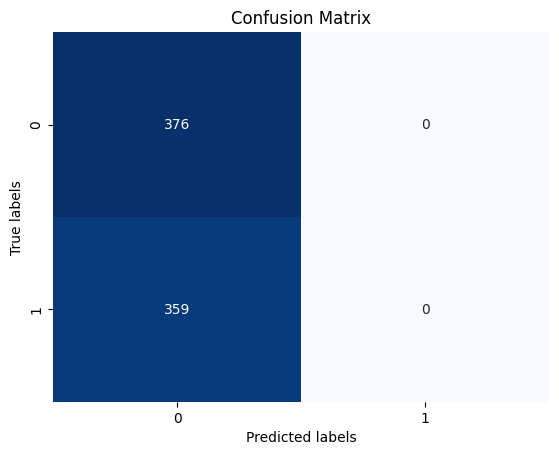

Random Guesser Report:
              precision    recall  f1-score   support

           0  0.51697128 0.52659574 0.52173913       376
           1  0.49431818 0.48467967 0.48945148       359

    accuracy                      0.50612245       735
   macro avg  0.50564473 0.50563771 0.50559530       735
weighted avg  0.50590671 0.50612245 0.50596870       735



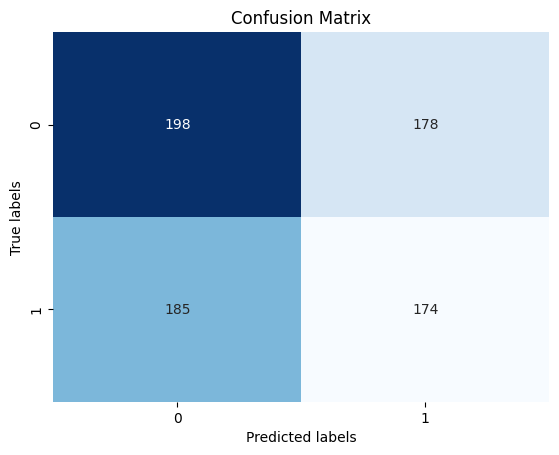

CountVectorizer with Logistic Regression Report:
              precision    recall  f1-score   support

           0  0.72423398 0.69148936 0.70748299       376
           1  0.69148936 0.72423398 0.70748299       359

    accuracy                      0.70748299       735
   macro avg  0.70786167 0.70786167 0.70748299       735
weighted avg  0.70824035 0.70748299 0.70748299       735



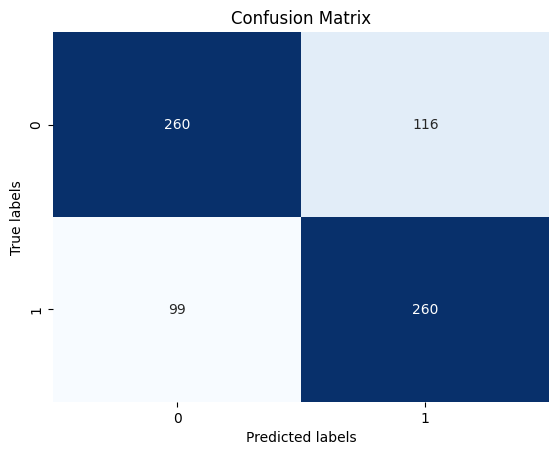

Neural Network Classifier Report:
              precision    recall  f1-score   support

           0  0.70175439 0.63829787 0.66852368       376
           1  0.65394402 0.71587744 0.68351064       359

    accuracy                      0.67619048       735
   macro avg  0.67784920 0.67708765 0.67601716       735
weighted avg  0.67840211 0.67619048 0.67584384       735



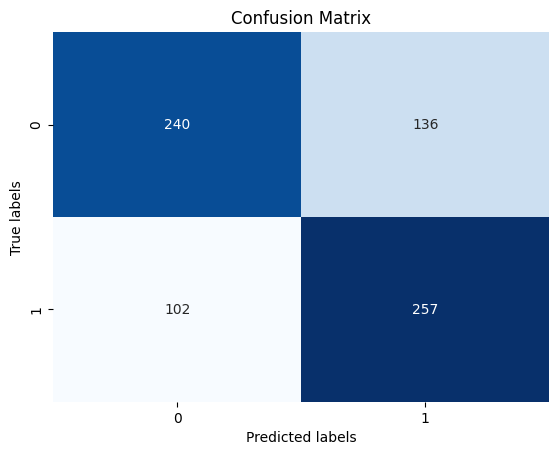

In [ ]:
# Assuming df is the DataFrame and "text" and "label_bias" are columns
X = df2['text']
y = df2['label_bias']

# Split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Majority Class Classifier
majority_class_classifier = DummyClassifier(strategy='most_frequent')
majority_class_classifier.fit(X_train_tfidf, y_train)
y_pred = majority_class_classifier.predict(X_test_tfidf)
print("Majority Class Classifier Report:")
print(classification_report(y_test, y_pred, digits=8))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='majority_class_classifier_cm_SG2.png')

# Random Guesser
random_guesser = DummyClassifier(strategy='uniform')
random_guesser.fit(X_train_tfidf, y_train)
y_pred = random_guesser.predict(X_test_tfidf)
print("Random Guesser Report:")
print(classification_report(y_test, y_pred, digits=8))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='random_guesser_cm_SG2.png')

# CountVectorizer with Logistic Regression
logistic_regression = LogisticRegression(tol=1e-5, max_iter=2000)
logistic_regression.fit(X_train_tfidf, y_train)
y_pred = logistic_regression.predict(X_test_tfidf)
print("CountVectorizer with Logistic Regression Report:")
print(classification_report(y_test, y_pred, digits=8))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='logistic_regression_cm_SG2.png')

# Neural network classifier with 10 layers, each with 100 neurons
neural_net = MLPClassifier(hidden_layer_sizes=(100,)*10, random_state=42)
neural_net.fit(X_train_tfidf, y_train)
y_pred = neural_net.predict(X_test_tfidf)
print("Neural Network Classifier Report:")
print(classification_report(y_test, y_pred, digits=8))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='neural_net_cm_SG2.png')


The last step is the interpretation of the model's predictions using the AnchorText explainer from the Alibi library. The explainer generates an explanation for a given text by finding a set of words that are highly predictive of the model's prediction. The explanation is returned as a set of words (the anchor) and a precision score, which is the model's prediction accuracy when the anchor is present in the text. The precision score is a measure of the anchor's reliability, and a higher precision score indicates a more reliable anchor. The threshold parameter is used to control the precision score, and the explainer will return an anchor with a precision score greater than or equal to the threshold.
The sampling_strategy parameter is used to control the sampling strategy for generating the anchor, and the nlp parameter is used to specify the spaCy model to be used for tokenization and similarity calculations.
The following code demonstrates how to use the AnchorText explainer to generate an explanation for a given text.
The similarity sampling strategy is used to generate the anchor, and the en_core_web_md spaCy model is used for tokenization and similarity calculations.
The reasons for selecting the similarity sampling strategy:
1. Similarity Sampling uses corpus embeddings to generate samples that are contextually similar to the original text. This will likely maintain the semantic context of the original text, which leads to more meaningful explanations.
2. This can make the explanations easier to understand for users, as the anchors are more interpretable.

To ensure the most optimum result for interpretation phase, the best model with respect to the F1 score(Macro variant) and SG2 dataset was chosen.
This model achieved a score of 0.8148 in previous step.

In [ ]:
os.system('python -m spacy download en_core_web_md')
nlp = spacy.load('en_core_web_md')

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Data_Sets/final_labels_SG2.xlsx')

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/final_labels_SG2.xlsx')

Showing the misclassified objects

In [ ]:
model = RobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('/content/drive/MyDrive/df2_c_Roberta_fine_tuned_pure.pt', map_location=device))

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

# The text for testing prediction ability
text = "Hello world!"

# Tokenize the text
inputs = tokenizer.encode_plus(
    text,
    add_special_tokens=True,  # add [CLS], [SEP]
    truncation=True,  # cut off at max length of the text that can go to BERT
    padding=True,
    return_attention_mask=True,  # add attention mask to not focus on pad tokens
    return_tensors='pt'  # return PyTorch tensors
)

# Get the prediction
with torch.no_grad():
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
_, preds = torch.max(outputs.logits, dim=1)

# Print the prediction
print('Predicted label:', preds.item())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-c71b6fdb60d4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explici

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Predicted label: 0


In [ ]:
# Assuming df2 is the DataFrame and "text" and "label_bias" are the columns
X = df2['text']
y = df2['label_bias']
vectorizer = CountVectorizer()
model = model.to(device)

# Using list Comprehension
y_pred = [
    torch.max(
        model(
            (inputs := tokenizer.encode_plus(
                text,
                add_special_tokens=True,  # add [CLS], [SEP]
                truncation=True,  # cut off at max length of the text that can go to BERT
                padding=True,
                return_attention_mask=True,  # add attention mask to not focus on pad tokens
                return_tensors='pt'  # return PyTorch tensors
            ))['input_ids'].to(device),
            attention_mask=inputs['attention_mask'].to(device)
        ).logits,
        dim=1
    )[1].item()
    for text in X
]

# Create a DataFrame to store the text, true labels, and predicted labels
df_results = pd.DataFrame({
    'text': X,
    'true_label': y,
    'predicted_label': y_pred
})

# Filter the DataFrame to only include instances where the true label does not match the predicted label
df_misclassified = df_results[df_results['true_label'] != df_results['predicted_label']]
df_misclassified.to_csv('misclassified.csv', index=False)

# Print the misclassified instances
print(df_misclassified.sample(12))


                                                   text  true_label  \
3240  Trump enjoys and encourages state brutality ag...           1   
848   Despite police officers in several parts of th...           0   
1170  He warned protestors not to use Floyd’s death ...           0   
2905  The Senate Republican leader said that some De...           0   
847   Despite fears that neo-Nazis or other extremis...           0   
2190  Rep. Alexandria Ocasio-Cortez (D-NY) has been ...           1   
378   As Congress begins debating the Equality Act, ...           1   
455   Authoritarianism experts who worried about Tru...           0   
467   Barrett argued in a 38-page opinion that the F...           0   
2118  President Trump sought to play down the threat...           1   
1267  If the Massachusetts Democrat’s proposal were ...           1   
1374  In New York City, the national epicenter of th...           1   

      predicted_label  
3240                0  
848                 1  
1170

# Evaluation by visual plots and model agnostics
The first methods used is the visualization of classification clusters and analyzing the distribution of sentences the second method would be to analyze using the AnchorText to interpret the the resulting classes using an explainer

In [ ]:
model_name = "prajjwal1/bert-tiny"
ex_tokenizer = AutoTokenizer.from_pretrained(model_name)
extractor_model = AutoModel.from_pretrained(model_name)
extractor = pipeline("feature-extraction", batch_size=512, model=extractor_model, tokenizer=ex_tokenizer)

def plot_tsne(vectors, labels, file_name, perplexity=30.0, n_iter=1000):
    """
    Compute and plot a t-SNE reduction of the given vectors and save the plot to a file.

    Arguments:
        vectors (list): A list of embedding vectors.
        labels (list): A list of class labels; must have the same length as `vectors`.
        file_name (str): The name of the file to save the plot.
        perplexity (float, optional): A hyperparameter of the t-SNE algorithm; recommended values
            are between 5 and 50, and can result in significantly different results. Defaults to 30.0.
        n_iter (int, optional): A hyperparameter of the t-SNE algorithm, controlling the maximum
            number of iterations of the optimization algorithm. Defaults to 1000.

    Returns:
        None. The function saves the plot to a file.
    """
    tsne = TSNE(verbose=True, perplexity=perplexity, n_iter=n_iter)
    vectors = np.stack(vectors.values)
    vectors_2d = tsne.fit_transform(np.array(vectors))

    # Create a scatter plot
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=labels, cmap='viridis')

    # Create a discrete color bar
    colorbar = plt.colorbar(scatter, ticks=range(np.min(labels), np.max(labels)+1))

    # Save the plot
    plt.savefig(file_name)


def extract_embeddings(sentences, token):
    """Encodes sentences and for each sentence, returns the vector corresponding to the given token.

    Arguments:
        sentences (list[str]): The sentences to feed into the model.
        token (str): The token to extract the embedding for.

    Returns:
        A list of vectors, one vector for each input sentence, corresponding to the contextual embedding
        of `token` within `sentence`. (This can be either a PyTorch tensor or a NumPy array.)
    """
    vectors = []
    for sentence in sentences:
        input_ids = ex_tokenizer(sentence)["input_ids"]
        token_id  = ex_tokenizer.vocab[token]
        token_idx = input_ids.index(token_id)
        output = extractor(sentence, return_tensors=True)
        vectors.append(output[0][token_idx][:].numpy())
    return vectors

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# Create True Labels
# Assuming df2 is the DataFrame and "text" and "label_bias" are the columns
model = RobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('/content/drive/MyDrive/df2_c_Roberta_fine_tuned_pure.pt', map_location=device))

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

model = model.to(device)

Sentences = df2['text']
TrueLabels = df2['label_bias']

# Create the Label lists from the Baselines and RoBERTa
texts_tfidf = vectorizer.transform(Sentences)
Labels_Majority = majority_class_classifier.predict(texts_tfidf)
Labels_Random = random_guesser.predict(texts_tfidf)
Labels_Logistic = logistic_regression.predict(texts_tfidf)

# Using list Comprehension
Labels_RoBERTa = [
    torch.max(
        model(
            (inputs := tokenizer.encode_plus(
                text,
                add_special_tokens=True,  # add [CLS], [SEP]
                truncation=True,  # cut off at max length of the text that can go to BERT
                padding=True,
                return_attention_mask=True,  # add attention mask to not focus on pad tokens
                return_tensors='pt'  # return PyTorch tensors
            ))['input_ids'].to(device),
            attention_mask=inputs['attention_mask'].to(device)
        ).logits,
        dim=1
    )[1].item()
    for text in X
]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-57dcca0da1f8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explici

In [ ]:
# create an inspection dataset containining the resulting labels from
df = pd.DataFrame({
    "Sentences": Sentences,
    "TrueLabels": TrueLabels,
    "Labels_Majority": Labels_Majority,
    "Labels_Random": Labels_Random,
    "Labels_Logistic": Labels_Logistic,
    "Labels_RoBERTa": Labels_RoBERTa
})

# Apply the function to the Sentences column and write the resulting embedding to a new column called Extracted_EMBD
df.insert(1, "Extracted_EMBD", extract_embeddings(df["Sentences"], '[CLS]'))

# Print the DataFrame
print(df.head(5))
df.to_csv('labels.csv', index=False)

# Create plots for each of the label column using Extracted_EMBD as vectors argument
label_columns = ["TrueLabels", "Labels_Majority", "Labels_Random", "Labels_Logistic", "Labels_RoBERTa"]
for label_column in label_columns:
    plot_tsne(df["Extracted_EMBD"], df[label_column], f"{label_column}_tsne_plot.png")

Output hidden; open in https://colab.research.google.com to view.

Next we can modify the ***plot_tsne*** function to encircle clusters of points in the t-SNE plot. \\
KMeans from sklearn.cluster is used for clustering the t-SNE results into regions. Circle from matplotlib.patches and ConvexHull from scipy.spatial are used to draw polygons around the clusters. \\
Also ***Encircle*** function is a helper function that takes the x and y coordinates of a set of points and draws a polygon around them. The polygon is determined by the convex hull of the points, which is the smallest convex polygon that contains all the points.

In [ ]:
from sklearn.cluster import KMeans
from matplotlib.patches import Circle
from scipy.spatial import ConvexHull

def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)


We can print misclassification by Region:

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3673 samples in 0.001s...
[t-SNE] Computed neighbors for 3673 samples in 0.279s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3673
[t-SNE] Computed conditional probabilities for sample 2000 / 3673
[t-SNE] Computed conditional probabilities for sample 3000 / 3673
[t-SNE] Computed conditional probabilities for sample 3673 / 3673
[t-SNE] Mean sigma: 2.123892
[t-SNE] KL divergence after 50 iterations with early exaggeration: 84.613434
[t-SNE] KL divergence after 1000 iterations: 2.621388


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Region 1 X: 2.889282464981079 - 58.749820709228516 Y: -19.679039001464844 - 30.110519409179688 Misclassified count: 70:
Sentence 1(TrueL 1): A cursory Twitter search reveals that accounts supporting the Antifa terrorist movement can easily be found on the platform.
Sentence 2(TrueL 0): A gaggle of representatives from theologically liberal denominations recently issued a statement against Christian nationalism in America, claiming that it threatens both American democracy and the ability of our religious communities to live in peace.
Sentence 3(TrueL 1): A president completely out of control, abusing government power to achieve his political ends, and desperate to prevent any check on his colossal Niagara Falls of bullshit, is about to make Twitter an object lesson, the first trophy in Trump's expanding war against free speech.
Sentence 4(TrueL 1): After all, who else are they going to find who would be willing to just openly gaslight members of Congress, telling them not to believe t

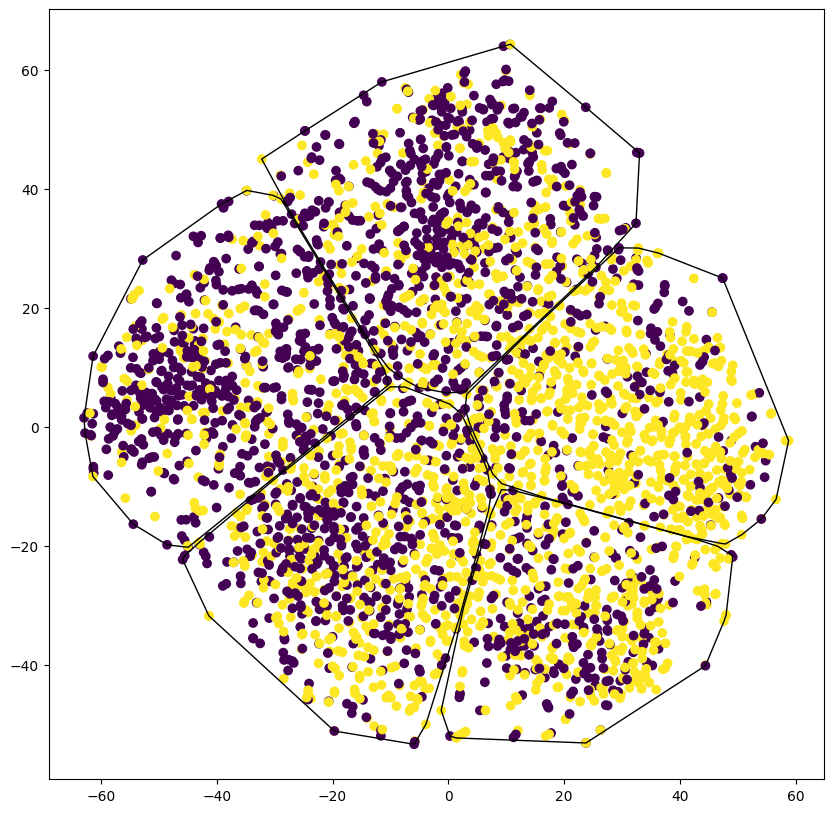

In [ ]:
def plot_tsne(vectors, labels, true_labels, sentences, file_name, num_regions, perplexity=30.0, n_iter=1000):

    tsne = TSNE(verbose=True, perplexity=perplexity, n_iter=n_iter)
    vectors = np.stack(vectors.values)
    vectors_2d = tsne.fit_transform(np.array(vectors))

    # Apply KMeans clustering to divide the t-SNE result into regions
    kmeans = KMeans(n_clusters=num_regions, random_state=23).fit(vectors_2d)
    region_labels = kmeans.labels_

    # Create a scatter plot
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=labels, cmap='viridis')

    # Encircle the clusters
    for i in range(num_regions):
        encircle(vectors_2d[region_labels == i, 0], vectors_2d[region_labels == i, 1], ec="k", fc="none")

    # Save the plot
    plt.savefig(file_name)

    # Print misclassified sentences in each region
    for i in range(num_regions):
        misclassified_sentences = sentences[(region_labels == i) & (labels != true_labels)]
        misclassified_true_labels = true_labels[(region_labels == i) & (labels != true_labels)]
        print(f"\nRegion {i+1} X: {min(vectors_2d[region_labels == i, 0])} - {max(vectors_2d[region_labels == i, 0])} Y: {min(vectors_2d[region_labels == i, 1])} - {max(vectors_2d[region_labels == i, 1])} Misclassified count: {len(misclassified_sentences)}:")
        if len(misclassified_sentences) == 0:
            print("All sentences classified correctly in this region.")
        else:
            for j, (sentence, true_label) in enumerate(zip(misclassified_sentences[:10], misclassified_true_labels[:10])):
                print(f"Sentence {j+1}(TrueL {true_label}): {sentence}")


plot_tsne(df["Extracted_EMBD"], df["Labels_Logistic"], df["TrueLabels"], df["Sentences"], "Labels_Logistic_tsne_plot.png", num_regions=5)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3673 samples in 0.001s...
[t-SNE] Computed neighbors for 3673 samples in 0.266s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3673
[t-SNE] Computed conditional probabilities for sample 2000 / 3673
[t-SNE] Computed conditional probabilities for sample 3000 / 3673
[t-SNE] Computed conditional probabilities for sample 3673 / 3673
[t-SNE] Mean sigma: 2.123892
[t-SNE] KL divergence after 50 iterations with early exaggeration: 84.613434
[t-SNE] KL divergence after 1000 iterations: 2.616421


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Region 1 X: -23.33285903930664 - 37.882568359375 Y: 5.405998706817627 - 64.55876159667969 Misclassified count: 0:
All sentences classified correctly in this region.

Region 2 X: -10.317757606506348 - 47.233577728271484 Y: -55.70567321777344 - -9.434379577636719 Misclassified count: 0:
All sentences classified correctly in this region.

Region 3 X: 3.260014057159424 - 59.74923324584961 Y: -26.509366989135742 - 28.059431076049805 Misclassified count: 0:
All sentences classified correctly in this region.

Region 4 X: -53.03764343261719 - 5.5225019454956055 Y: -49.446250915527344 - 8.513533592224121 Misclassified count: 0:
All sentences classified correctly in this region.

Region 5 X: -64.53821563720703 - -10.978537559509277 Y: -12.863167762756348 - 42.76569366455078 Misclassified count: 0:
All sentences classified correctly in this region.


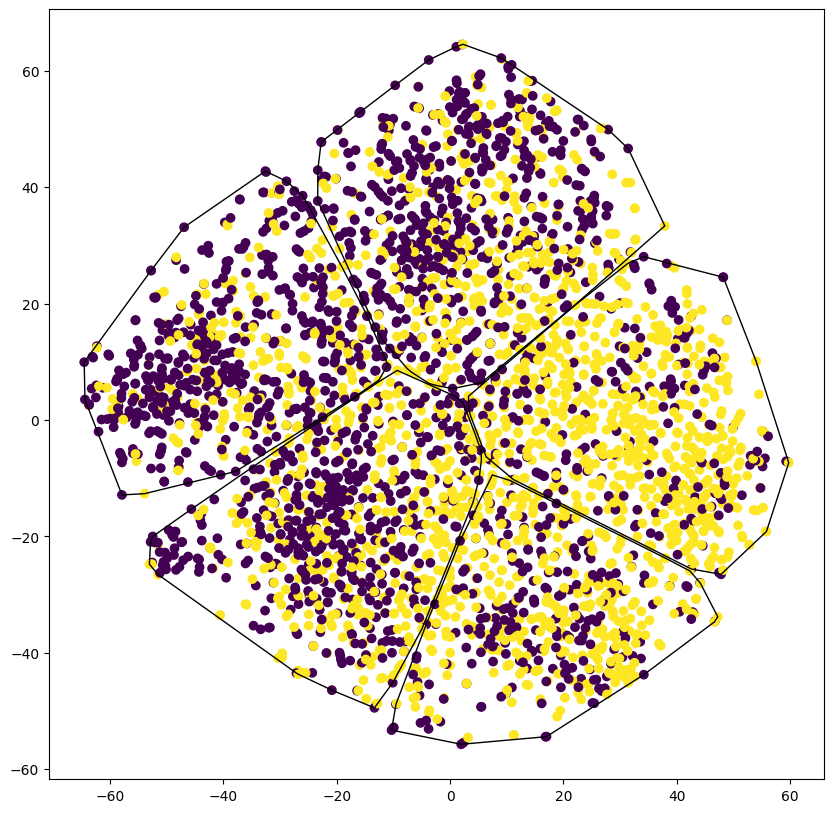

In [ ]:
plot_tsne(df["Extracted_EMBD"], df["TrueLabels"], df["TrueLabels"], df["Sentences"], "TrueLabels_tsne_plot.png", num_regions=5)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3673 samples in 0.001s...
[t-SNE] Computed neighbors for 3673 samples in 0.296s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3673
[t-SNE] Computed conditional probabilities for sample 2000 / 3673
[t-SNE] Computed conditional probabilities for sample 3000 / 3673
[t-SNE] Computed conditional probabilities for sample 3673 / 3673
[t-SNE] Mean sigma: 2.123892
[t-SNE] KL divergence after 50 iterations with early exaggeration: 84.613434
[t-SNE] KL divergence after 1000 iterations: 2.611874


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Region 1 X: 3.0099215507507324 - 59.51438903808594 Y: -25.332096099853516 - 33.37728500366211 Misclassified count: 48:
Sentence 1(TrueL 1): A cursory Twitter search reveals that accounts supporting the Antifa terrorist movement can easily be found on the platform.
Sentence 2(TrueL 0): A gaggle of representatives from theologically liberal denominations recently issued a statement against Christian nationalism in America, claiming that it threatens both American democracy and the ability of our religious communities to live in peace.
Sentence 3(TrueL 0): Antifa, short for “anti-fascist,” is an amorphous movement whose adherents oppose people or groups they consider authoritarian or racist, often using aggressive tactics, according to the Anti-Defamation League (ADL)
Sentence 4(TrueL 1): Anti-vaxxers represent only about 2 percent of American families, although you’d be forgiven for thinking they’re more numerous. They certainly make a lot of noise and have some world-famous adherents. 

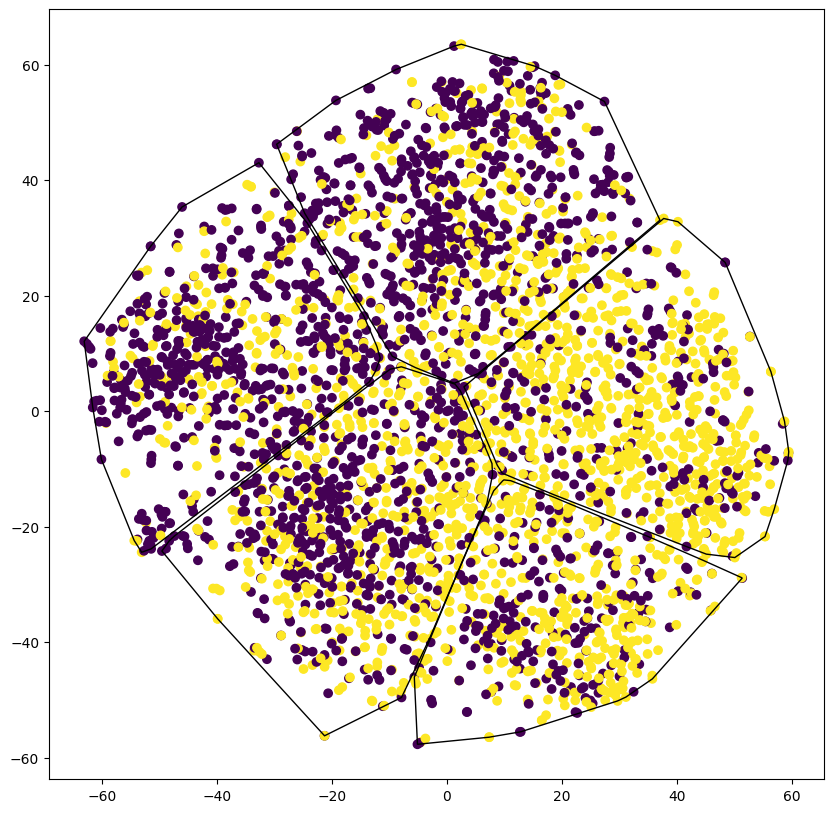

In [ ]:
plot_tsne(df["Extracted_EMBD"], df["Labels_RoBERTa"], df["TrueLabels"], df["Sentences"], "Labels_RoBERTa_tsne_plot.png", num_regions=5)

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
model = RobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/df2_c_Roberta_fine_tuned_pure.pt', map_location=device))

def predict_fn(texts):
    predictions = [
        torch.max(
            model(
                (inputs := tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,  # add [CLS], [SEP]
                    truncation=True,  # cut off at max length of the text that can go to BERT
                    padding=True,  # add [PAD] tokens
                    return_attention_mask=True,  # add attention mask to not focus on pad tokens
                    return_tensors='pt'  # return PyTorch tensors
                ))['input_ids'].to(device),
                attention_mask=inputs['attention_mask'].to(device)
            ).logits,
            dim=1
        )[1].item()
        for text in texts
    ]
    return np.array(predictions, dtype=np.int64)

print(predict_fn(['The findings suggest childhood vaccination efforts nearly ground to a halt between March 13 — when the national emergency was declared — and April 19']))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-42-be4ac1c7c25b>:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explic

[0]


In [ ]:
# Define the predict function
# def predict_fn(texts):
#     predictions = []
#     for text in texts:
#         # Tokenize the text
#         inputs = tokenizer.encode_plus(
#             text,
#             add_special_tokens=True,  # add [CLS], [SEP]
#             truncation=True,  # cut off at max length of the text that can go to BERT
#             padding=True,  # add [PAD] tokens
#             return_attention_mask=True,  # add attention mask to not focus on pad tokens
#             return_tensors='pt'  # return PyTorch tensors
#         )
#         # Get the prediction
#         with torch.no_grad():
#             outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
#         _, preds = torch.max(outputs.logits, dim=1)
#         predictions.append(preds.item())
#     return np.array(predictions, dtype=np.int64)
# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
model = RobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/df2_c_Roberta_fine_tuned_pure.pt', map_location=device))

def predict_fn(texts):
    predictions = [
        torch.max(
            model(
                (inputs := tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,  # add [CLS], [SEP]
                    truncation=True,  # cut off at max length of the text that can go to BERT
                    padding=True,  # add [PAD] tokens
                    return_attention_mask=True,  # add attention mask to not focus on pad tokens
                    return_tensors='pt'  # return PyTorch tensors
                ))['input_ids'].to(device),
                attention_mask=inputs['attention_mask'].to(device)
            ).logits,
            dim=1
        )[1].item()
        for text in texts
    ]
    return np.array(predictions, dtype=np.int64)

explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)
explanation = explainer.explain('A Biden victory would ensure government-imposed thought-police courses that are anti-history, anti-free thought, anti-White, and anti-male.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-45-8270b0286631>:25: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are expli

Anchor: 
Precision: 1.00


<ipython-input-45-8270b0286631>:52: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [ ]:
# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('Civil rights activists across the United States for years have called for scaling back traditional policing, and the efforts have gained momentum through protests over the death of George Floyd in Minneapolis police custody last month.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)


Anchor: called AND protests AND activists AND death AND scaling AND momentum
Precision: 0.95


In [ ]:
# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('An attorney for President Donald Trump on Friday blasted U.S. House Democrats’ request for six years of Trump’s tax returns as “a misguided attempt” to politicize the tax laws, accusing lawmakers of harassment and interference in IRS audits.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)


Anchor: blasted
Precision: 1.00


In [ ]:
# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('Japan has reported about 1300 deaths from COVID-19 but new cases in Tokyo have fallen in the last few weeks', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Anchor: fallen AND few AND last
Precision: 0.95


In [ ]:
# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('The idea of a "rigged" economy that both benefits and is shaped by the rich and powerful was a popular theme in 2016 and is sure to play a big role again this cycle with several Democratic candidates emphasizing it on the campaign trail.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Anchor: big AND idea AND rich AND theme AND powerful AND rigged AND a AND play AND popular AND campaign AND cycle AND again AND several AND emphasizing AND shaped AND of
Precision: 0.95


In [ ]:
# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('A good conclusion to draw might be that the charity of the top 0.1 percent and of corporations both are vastly overstated and not even fractionally as useful as simply taxing them at the same effective rate as the rest of us pay, so maybe we should get on with that already', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)


Anchor: maybe AND good AND rest AND already AND top AND effective AND get AND draw AND fractionally AND at AND simply AND conclusion AND same AND charity AND overstated AND useful AND vastly AND rate
Precision: 0.96


In [ ]:
# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('As you know, this is a very high priority for the president, ending surprise medical bills.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Anchor: very AND surprise AND priority AND high AND ending AND medical AND for AND president
Precision: 0.97


In [ ]:
# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('The findings suggest childhood vaccination efforts nearly ground to a halt between March 13 — when the national emergency was declared — and April 19.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Anchor: halt AND a AND efforts AND declared AND childhood AND between
Precision: 0.98


In [ ]:
# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('Vaccine critics, for example, have long championed the false claim that vaccines cause autism, and that the Centers for Disease Control and Prevention has tried to cover up that information, Gorski said.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Anchor: championed AND false
Precision: 0.98


In [ ]:
predict_fn(['Civil rights activists across the United States for years have called for scaling back traditional policing, and the efforts have gained momentum through protests over the death of George Floyd in Minneapolis police custody last month.'])

array([0])

In [ ]:
predict_fn(['An attorney for President Donald Trump on Friday blasted U.S. House Democrats’ request for six years of Trump’s tax returns as “a misguided attempt” to politicize the tax laws, accusing lawmakers of harassment and interference in IRS audits.'])

array([1])

In [ ]:
predict_fn(['Japan has reported about 1300 deaths from COVID-19 but new cases in Tokyo have fallen in the last few weeks'])

array([0])

In [ ]:
predict_fn(['The idea of a "rigged" economy that both benefits and is shaped by the rich and powerful was a popular theme in 2016 and is sure to play a big role again this cycle with several Democratic candidates emphasizing it on the campaign trail.'])

array([0])

In [ ]:
predict_fn(['As you know, this is a very high priority for the president, ending surprise medical bills.'])

array([0])

In [ ]:
predict_fn(['The findings suggest childhood vaccination efforts nearly ground to a halt between March 13 — when the national emergency was declared — and April 19'])

array([0])

In [ ]:
predict_fn(['Vaccine critics, for example, have long championed the false claim that vaccines cause autism, and that the Centers for Disease Control and Prevention has tried to cover up that information, Gorski said.'])

array([1])

In [ ]:
predict_fn(['A good conclusion to draw might be that the charity of the top 0.1 percent and of corporations both are vastly overstated and not even fractionally as useful as simply taxing them at the same effective rate as the rest of us pay, so maybe we should get on with that already'])

array([0])

In [ ]:
!cp *.png "/content/drive/MyDrive/Plots/"



In [ ]:
!cp *.csv "/content/drive/MyDrive/Plots/"

In [ ]:
!cp *.* "/content/drive/MyDrive/Models/Results/"

The next following cells were used to experiment for the aim of identifying good additional layers, in my experiment the best f1 score with the addition of RoBERTa could reach 82.50\% but this result will be investigated further with a larger and more suitable dataset.

In [ ]:
# Tokenize the text data
max_words = 10000  # Maximum number of words to keep based on word frequency
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_resampled)
y_train_resampled = np.array(y_train_resampled)

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train_resampled)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
max_len = 100  # Maximum sequence length (pad/truncate sequences to this length)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Define the model
embedding_dim = 100
model = Sequential()
# temporarily adding embedding to experiment with the model
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=l1(0.001)))  # L1 Regularization
model.add(MaxPooling1D(5))
model.add(BatchNormalization())
model.add(GRU(128, return_sequences=True, dropout=0.0, recurrent_dropout=0.0, kernel_regularizer=l2(0.001)))  # L2 Regularization
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))  # Elastic Net Regularization
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))  # Elastic Net Regularization
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

optimizer = Adam(learning_rate=1e-4)  # Adjusted learning rate

# Compile the model with custom optimizer
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
print(model.summary())


# Train the model
history = model.fit(X_train_pad, y_train_resampled,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val_pad, y_val),
                    verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')

# save history model
model.save('/content/drive/MyDrive/Models/In_data/history_dense_1.h5')







In [ ]:
# Define the model
embedding_dim = 100
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=l1(0.001)))  # L1 Regularization
model.add(MaxPooling1D(5))
model.add(BatchNormalization())
model.add(GRU(128, return_sequences=True, dropout=0.0, recurrent_dropout=0.0, kernel_regularizer=l2(0.001)))  # L2 Regularization
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))  # Elastic Net Regularization
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))  # Elastic Net Regularization
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # Output layer with 2 units and softmax activation

optimizer = Adam(learning_rate=1e-4)  # Adjusted learning rate

# Compile the model with custom optimizer
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  # Updated loss function
              metrics=['accuracy'])

# Print the model summary
print(model.summary())

# One-hot encode the target variables
y_train_resampled_one_hot = to_categorical(y_train_resampled, num_classes=2)
y_val_one_hot = to_categorical(y_val, num_classes=2)


# Train the model
history = model.fit(X_train_pad, y_train_resampled_one_hot,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val_pad, y_val_one_hot),
                    verbose=1)

# save history model
model.save('/content/drive/MyDrive/Models/In_data/history_dense_1.keras')

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_10 (GRU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_9               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5004 - loss: 14.5898 - val_accuracy: 0.4758 - val_loss: 13.9148
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5071 - loss: 13.7073 - val_accuracy: 0.4718 - val_loss: 13.0650
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5519 - loss: 12.8502 - val_accuracy: 0.4718 - val_loss: 12.2450
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5495 - loss: 12.0396 - val_accuracy: 0.4758 - val_loss: 11.4565
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5770 - loss: 11.2459 - val_accuracy: 0.4718 - val_loss: 10.7025
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6012 - loss: 10.4998 - val_accuracy: 0.4798 - val_loss: 9.9847
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7267 - loss: 9.7522 - val_accuracy: 0.5403 - val_loss: 9.3059
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8339 - loss: 9.0391 - 

In [ ]:

# Predict on test set
y_pred = model.predict(X_test_pad).flatten()
y_pred = (y_pred > 0.5).astype(int)
# Convert y_test to numpy array for compatibility

y_true = y_test

# Calculate metrics
# Flatten y_true if it's not already flattened
if y_true.ndim > 1:
    y_true = y_true.flatten()

plot_confusion_matrix(y_true, y_pred, classes=np.unique(y_true), filename='confusion_matrix.png')
# Calculate metrics
val_acc = accuracy_score(y_true, y_pred)
val_prec = precision_score(y_true, y_pred, average='binary')
val_rec = recall_score(y_true, y_pred, average='binary')
val_f1 = f1_score(y_true, y_pred, average='binary')

print(f'Test Accuracy: {val_acc:.4f}')
print(f'Precision: {val_prec:.4f}')
print(f'Recall: {val_rec:.4f}')
print(f'F1 Score: {val_f1:.4f}')

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Additionally we can interpret the clustering Through training decision trees on
every cluster as follow:

In [ ]:
from sklearn.cluster import KMeans
from matplotlib.patches import Circle
from scipy.spatial import ConvexHull

def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)



def analyze_clusters(sentences, cluster_labels):
    cluster_analysis = {}
    vectorizer = TfidfVectorizer(stop_words='english')

    # Ensure sentences is a list for proper indexing
    sentences = sentences.tolist()  # Convert Series to list

    for cluster in np.unique(cluster_labels):
        # Extract sentences belonging to the current cluster
        cluster_sentences = [sentences[i] for i in range(len(sentences)) if cluster_labels[i] == cluster]

        # TF-IDF analysis to find common words
        tfidf_matrix = vectorizer.fit_transform(cluster_sentences)
        tfidf_feature_names = vectorizer.get_feature_names_out()
        average_tfidf = tfidf_matrix.mean(axis=0).A1
        top_words = [tfidf_feature_names[i] for i in np.argsort(average_tfidf)[-10:]]  # Top 10 words

        # Additional Metrics
        avg_sentence_length = np.mean([len(sentence.split()) for sentence in cluster_sentences])

        cluster_analysis[cluster] = {
            "Top Words": top_words,
            "Average Sentence Length": avg_sentence_length,
            "Number of Sentences": len(cluster_sentences)
        }

    return cluster_analysis

def plot_tsne(vectors, labels, true_labels, sentences, file_name, num_regions, perplexity=30.0, n_iter=1000):

    tsne = TSNE(verbose=True, perplexity=perplexity, n_iter=n_iter)
    vectors = np.stack(vectors.values)
    vectors_2d = tsne.fit_transform(np.array(vectors))

    # Apply KMeans clustering to divide the t-SNE result into regions
    kmeans = KMeans(n_clusters=num_regions, random_state=23).fit(vectors_2d)
    region_labels = kmeans.labels_

    # Train a decision tree to interpret the clusters
    X_train, X_test, y_train, y_test = train_test_split(vectors_2d, region_labels, test_size=0.3, random_state=42)
    tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    tree_clf.fit(X_train, y_train)

    # print the depth
    print(f'Decision Tree Depth: {tree_clf.get_depth()}')
    # Calculate accuracy on the test set
    y_pred = tree_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Decision Tree Accuracy: {accuracy:.4f}')

    # Plot the decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(tree_clf, filled=True, feature_names=['Dim1', 'Dim2'], class_names=[f'Cluster {i}' for i in range(num_regions)])
    plt.title('Decision Tree to Interpret Clusters')
    plt.savefig(file_name.replace('.png', '_decision_tree.svg'))

    # Create a scatter plot
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=labels, cmap='viridis')

    # Encircle the clusters
    for i in range(num_regions):
        encircle(vectors_2d[region_labels == i, 0], vectors_2d[region_labels == i, 1], ec="k", fc="none")

    # Save the plot
    plt.savefig(file_name)

    # Print misclassified sentences in each region
    for i in range(num_regions):
        misclassified_sentences = sentences[(region_labels == i) & (labels != true_labels)]
        misclassified_true_labels = true_labels[(region_labels == i) & (labels != true_labels)]
        print(f"\nRegion {i+1} X: {min(vectors_2d[region_labels == i, 0])} - {max(vectors_2d[region_labels == i, 0])} Y: {min(vectors_2d[region_labels == i, 1])} - {max(vectors_2d[region_labels == i, 1])} Misclassified count: {len(misclassified_sentences)}:")
        if len(misclassified_sentences) == 0:
            print("All sentences classified correctly in this region.")
        else:
            for j, (sentence, true_label) in enumerate(zip(misclassified_sentences[:10], misclassified_true_labels[:10])):
                print(f"Sentence {j+1}(TrueL {true_label}): {sentence}")

    # Analyze the patterns in sentences for each cluster
    cluster_analysis = analyze_clusters(sentences, region_labels)

    return cluster_analysis


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3673 samples in 0.001s...
[t-SNE] Computed neighbors for 3673 samples in 0.553s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3673
[t-SNE] Computed conditional probabilities for sample 2000 / 3673
[t-SNE] Computed conditional probabilities for sample 3000 / 3673
[t-SNE] Computed conditional probabilities for sample 3673 / 3673
[t-SNE] Mean sigma: 2.123892
[t-SNE] KL divergence after 50 iterations with early exaggeration: 84.613495
[t-SNE] KL divergence after 1000 iterations: 2.622356
Decision Tree Depth: 3
Decision Tree Accuracy: 0.8648


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Region 1 X: -1.2331411838531494 - 52.8450813293457 Y: -56.083595275878906 - -13.252896308898926 Misclassified count: 40:
Sentence 1(TrueL 0): ‘Woke’ is not a dirty word but a moral duty, says a senior BBC editor, defending the corporation’s decision to ‘repurpose’ classic novels by giving them more black, female and Asian characters even when this is historically inaccurate.
Sentence 2(TrueL 1): A city council member in Minneapolis was quoted as claiming that there had been no looting or burning on the first night of the protest, and that police were to blame for subsequent events because they were “incredibly brutal” in response.
Sentence 3(TrueL 1): A young, slender woman with a sign reading “End All Violence” stood at the doors and pleaded with the looters to stop. 
Sentence 4(TrueL 1): Appearing Tuesday Cheddar Live, Rep. Maxine Waters (D) formally endorsed former Vice President Joe Biden for the White House, claiming that President Donald Trump is “destroying America” and advocat

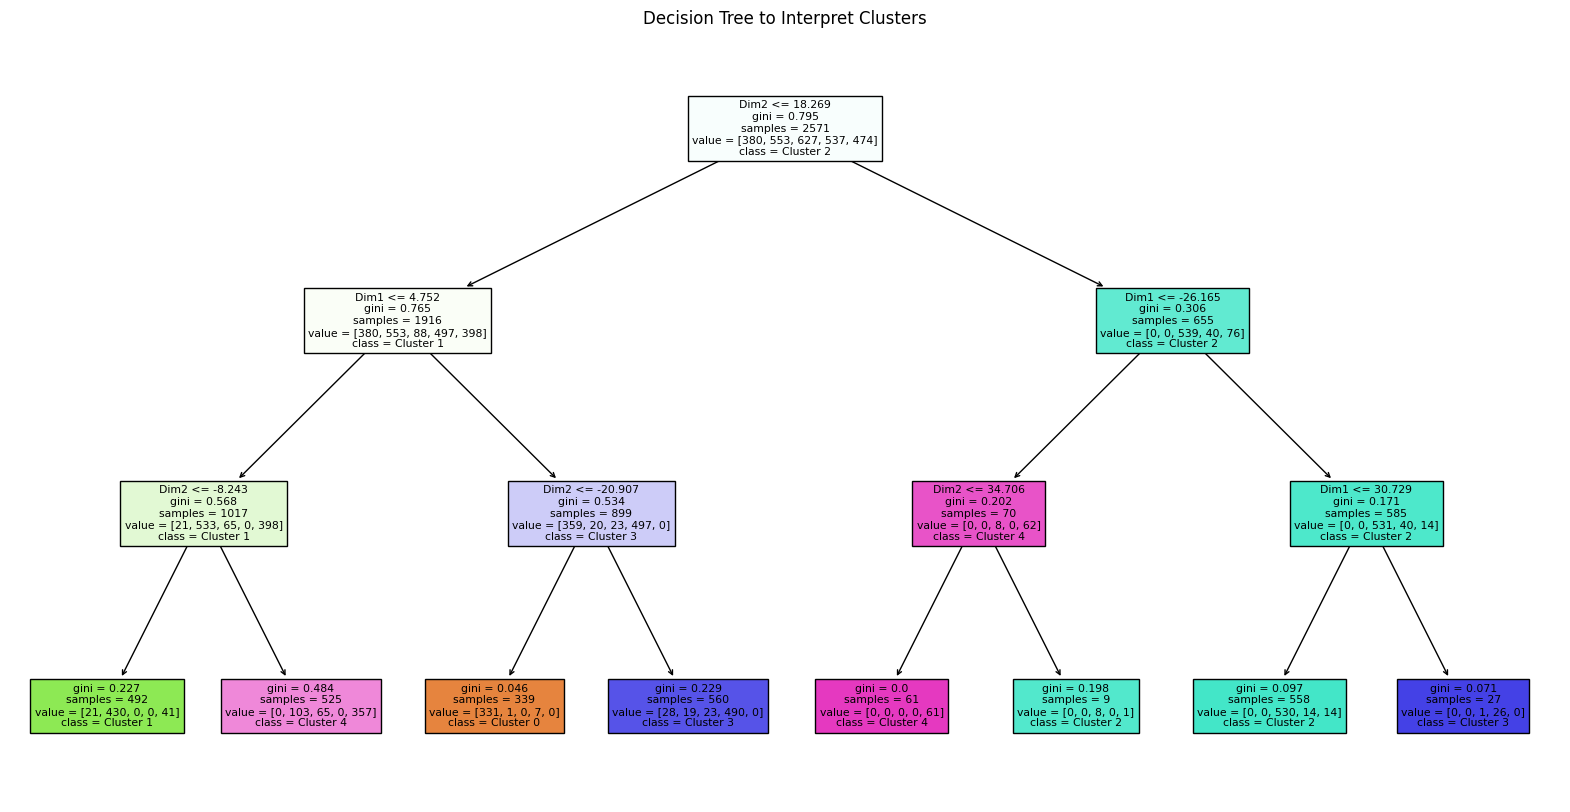

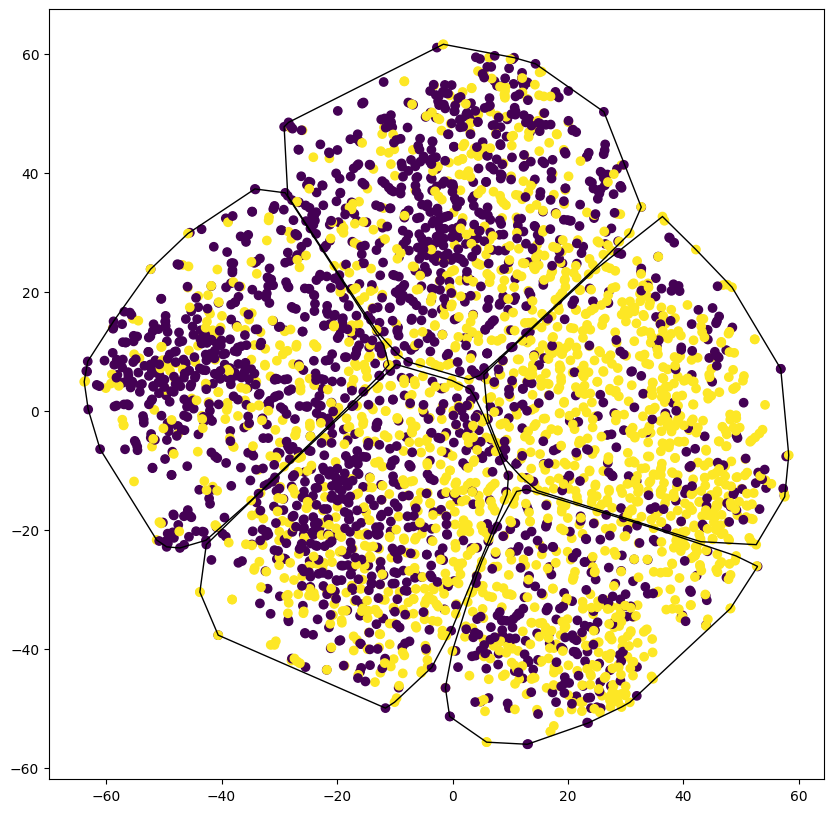

In [ ]:
# Example usage
cluster_analysis = plot_tsne(df["Extracted_EMBD"], df["Labels_RoBERTa"], df["TrueLabels"], df["Sentences"],
                             "Labels_RoBERTa_tsne_plot.png", num_regions=5)

# Display the analysis results
for cluster, analysis in cluster_analysis.items():
    print(f"Cluster {cluster}:")
    print(f"  Top Words: {', '.join(analysis['Top Words'])}")
    print(f"  Average Sentence Length: {analysis['Average Sentence Length']}")
    print(f"  Number of Sentences: {analysis['Number of Sentences']}")
    print()

In [ ]:
!cp *.* "/content/drive/MyDrive/Models/new_experiment"